In [1]:
# 1. Import libraries:
%matplotlib inline
import os
import quandl
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
from scipy.stats import kurtosis, skew
import seaborn as sns
# from financial_data import *
import tensorflow as tf
mlp.style.use('seaborn')
quandl.save_key('HtwBLPt3k37yZHTvy15K')

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_4737/4242266090.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mlp.style.use('seaborn')


In [2]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(sp_url, header=0)[0]
sp500.head()



,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
# Correct invalid dates:
sp500.loc[sp500[sp500['Date added']=='1983-11-30 (1957-03-04)'].index,'Date added'] = '1983-11-30'
sp500.loc[sp500[sp500['Date added']=='2001?'].index,'Date added'] = '2001-01-01'
# Filter firms that entered the index after December 2015:
sp500['Date added'] = pd.to_datetime(sp500['Date added'],format='%Y-%m-%d')
sp500 = sp500[sp500['Date added']<'2007-01-01']
print("The number of stocks in the universe is:", sp500.shape[0])

The number of stocks in the universe is: 241


In [4]:
n_stocks = 2
np.random.seed(1792)
universe_tickers = sp500['Symbol'].unique()
tickers = list(np.random.choice(universe_tickers,replace=False,size=n_stocks))
print(tickers)
# sp500[sp500['Symbol'].isin(portfolio_tickers)]

['DIS', 'BIIB']


In [5]:
# tickers = ['AAPL', 'GOOGL', 'MSFT','SPY']
# start_date='2007-01-01'
# end_date='2022-12-31'
# columns = ['Adj Close', 'Volume']
# # Download data
# data = yf.download(tickers, start=start_date, end=end_date)[columns]

# # 'data' will be a Pandas DataFrame containing the historical data for the specified tickers
# print(data)


def download_data(tickers, start_date, end_date, columns):
    data = yf.download(tickers, start=start_date, end=end_date)
    data=data[columns]
    return data

# Define the tickers, start date, end date, and columns you want to download
# tickers = ['AAPL', 'GOOGL', 'MSFT']
start_date = '2007-01-01'
end_date = '2022-12-31'
columns = [ 'Adj Close', 'Volume','Open','High','Low']

# Download the data
data = download_data(tickers, start_date, end_date, columns)
print(data)


def one_lvl_colnames(df,cols,tickers):
    """This function changes a multi-level column indexation into a one level
    column indexation

    Inputs:
    -------
    df (pandas Dataframe): dataframe with the columns whose indexation will be 
        flattened.
    tickers (list|string): list/string with the tickers (s) in the data frame df.
    cols (list|string): list/string with the name of the columns (e.g. 'Adj Close',
        'High', 'Close', etc.) that are in the dataframe df.
    
    Ouputs:
    -------
    df (pandas Dataframe): dataframe with the same information as df, but 
        with one level of indexation.
    """
    
    
    print("the dataframe before the columns were renamed")
#     print(df.columns)
    df_not_renamed=df.copy()
#     df_not_renamed.drop("Open",inplace=True)
    print(df_not_renamed.columns)
    # Define important variables:
    if isinstance(tickers, str):
        tickers = [tickers]
    if isinstance(cols, str):
        
        cols = [cols]
        print(cols)

    # For multi-level column indexing:
    if isinstance(df.columns.values[0], tuple):

        # Define important varibles
        columns = df.columns.values
        new_cols = []

        # Itarate through the multi-level column names and flatten them:
        for col in columns:
            temp = []
            for name in col:
                if name != '':
                    temp.append(name)
            new_temp = '_'.join(temp)
            new_cols.append(new_temp)
        
        # Change the column names:
        df.columns = new_cols
        print(df.columns)
    
    # For uni-level colum indexing:
    elif isinstance(df.columns.values[0], str):
        
        # Define new names:
        col_names = [column+'_'+ticker for column in cols\
                     for ticker in tickers]
        df.columns = col_names
    
    print("the dataframe after the columns have been renamed") 
#     print(df)

    return df

df2=pd.DataFrame(one_lvl_colnames(data,cols=columns,tickers=tickers))
df2_columns=list(df2.columns)
df2.columns = [col.replace('Adj Close', 'Close') for col in df2_columns]
df2.fillna(method='ffill',inplace=True)
df2.fillna(method='bfill',inplace=True)
df2

[*********************100%%**********************]  2 of 2 completed
             Adj Close              Volume                  Open             \
                  BIIB        DIS     BIIB       DIS        BIIB        DIS   
Date                                                                          
2007-01-03   49.330002  28.317101  3833500  13562595   49.279999  33.748165   
2007-01-04   49.750000  28.540655  2884300   9806285   49.270000  33.738300   
2007-01-05   49.759998  28.308819  2230400  10551445   49.990002  33.807354   
2007-01-08   50.020000  28.565489  3160200   9479676   50.000000  33.728436   
2007-01-09   49.500000  28.524092  2816500  11588444   49.880001  34.034248   
...                ...        ...      ...       ...         ...        ...   
2022-12-23  279.160004  88.010002   624800  11171600  280.450012  86.059998   
2022-12-27  274.769989  86.370003   638600  11561400  279.890015  87.419998   
2022-12-28  274.040009  84.169998   521000  12399500  275.6400

,Close_BIIB,Close_DIS,Volume_BIIB,Volume_DIS,Open_BIIB,Open_DIS,High_BIIB,High_DIS,Low_BIIB,Low_DIS
Date,,,,,,,,,,
2007-01-03,49.330002,28.317101,3833500,13562595,49.279999,33.748165,50.250000,34.073711,48.200001,33.531136
2007-01-04,49.750000,28.540655,2884300,9806285,49.270000,33.738300,50.099998,34.083576,48.880001,33.708706
2007-01-05,49.759998,28.308819,2230400,10551445,49.990002,33.807354,50.330002,33.975060,49.509998,33.531136
2007-01-08,50.020000,28.565489,3160200,9479676,50.000000,33.728436,50.160000,34.162495,48.910000,33.610054
2007-01-09,49.500000,28.524092,2816500,11588444,49.880001,34.034248,50.139999,34.221684,49.299999,33.491676
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,279.160004,88.010002,624800,11171600,280.450012,86.059998,280.450012,88.070000,276.070007,85.769997
2022-12-27,274.769989,86.370003,638600,11561400,279.890015,87.419998,279.890015,87.940002,273.380005,85.959999
2022-12-28,274.040009,84.169998,521000,12399500,275.640015,86.080002,276.920013,86.690002,272.640015,84.070000


In [6]:
from stockstats import StockDataFrame
def extract_and_wrap_ticker_data(df, columns):
    # Split column names into parts
    parts = [col.split('_') for col in columns]

    # Create a dictionary to store information about each ticker
    ticker_info = {}

    # Iterate through the parts list
    for part in parts:
        data_type = part[0]  # e.g., 'Adj Close', 'Close', etc.
        ticker = part[1]     # e.g., 'AAPL', 'GOOGL', etc.

        # Check if the ticker is already in the dictionary
        if ticker not in ticker_info:
            ticker_info[ticker] = {}

        # Add information for the ticker
        ticker_info[ticker][data_type] = df[f'{data_type}_{ticker}']

    # Create a dictionary to store stockstats DataFrames for each ticker
    ticker_dataframes = pd.DataFrame()
#     var_importance_all=

    # Iterate through ticker_info and wrap data with stockstats
    for ticker, data in ticker_info.items():
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        df = pd.DataFrame(data)
        print(ticker)
#         print(df)
        
        stock_df = StockDataFrame.retype(df)
#         print(stock_df)


        stock_df['cci_14']
        stock_df['stochrsi_14']
#         stock_df['ichimoku cloud']=stock_df['ichimoku cloud']
        stock_df['boll']
        stock_df['close_14_sma']
        stock_df['close_14_roc']
        stock_df['mfi_14']
        stock_df['bop_14']
        stock_df['supertrend_14']
        stock_df['eribull_14']
#         stock_df['cti_14']
#         stock_df['qqe_14']
        stock_df['ker_14']
        print(stock_df.head(26))
#         roll_stat=rolling_statistics(stock_df,cols='close',
#                       window=14)
#         stock_df = pd.concat([stock_df,roll_stat],axis=1)
        print("&&&&&&&&&&&&&&&&&&&&&&&&")
#         
        

        stock_df.columns = [ticker+"_" + col for col in pd.DataFrame(stock_df).columns]
        ticker_dataframes = pd.concat([ticker_dataframes,stock_df],axis=1)
        
    return ticker_dataframes

# Sample DataFrame with specified columns
columns = list(df2.columns)



# Extract and wrap ticker data
ticker_dataframes = extract_and_wrap_ticker_data(df2, columns)

# Access information for a specific ticker (e.g., AAPL)
# print(ticker_dataframes)

# ticker_dataframes

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BIIB
                close   volume       open       high        low      cci_14  \
Date                                                                          
2007-01-03  49.330002  3833500  49.279999  50.250000  48.200001         NaN   
2007-01-04  49.750000  2884300  49.270000  50.099998  48.880001   66.666667   
2007-01-05  49.759998  2230400  49.990002  50.330002  49.509998   97.111977   
2007-01-08  50.020000  3160200  50.000000  50.160000  48.910000   35.474059   
2007-01-09  49.500000  2816500  49.880001  50.139999  49.299999   16.288392   
2007-01-10  49.279999  3161600  49.230000  49.549999  48.820000 -107.091180   
2007-01-11  50.439999  2847900  49.340000  50.630001  49.099998  128.500386   
2007-01-12  50.970001  3147800  50.360001  51.369999  50.360001  200.782685   
2007-01-16  51.799999  2710000  51.200001  51.849998  50.500000  173.213448   
2007-01-17  51.900002  3963000  51.480000  52.450001  51.410000  157.279760   
2007-01-18

In [7]:
# Define the tickers
new_tickers = ['EIA/PET_RWTC_D','FRED/T10Y2Y','FRED/T10Y3M','FRED/DTB3','FRED/DLTIIT','FRED/TEDRATE']

# # Define the date range
# start='2020-01-01'
# end='2021-01-01'
names = ['wti_spot','10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread']
# add_factors = quandl.get(tickers, start=start_date, end=end_date)

# # Retrieve data
data_quandl = quandl.get(new_tickers, start_date=start_date, end_date=end_date)
data_quandl.columns = names
data_quandl['var_wti'] = data_quandl['wti_spot'].pct_change()
# print(data_quandl)

# # Fill NaN values:
# data_quandl.fillna(method='ffill',inplace=True)
# data_quandl.fillna(method='bfill',inplace=True)


# # Print the data
print(data_quandl)



            wti_spot  10y2y_spread  10y3m_spread  3m_rate  ltiit  ted_spread  \
Date                                                                           
2007-01-02     60.77         -0.12         -0.39     4.94   2.33        0.42   
2007-01-03     58.31         -0.09         -0.38     4.92   2.32        0.44   
2007-01-04     55.65         -0.09         -0.42     4.91   2.30        0.45   
2007-01-05     56.29         -0.11         -0.40     4.92   2.33        0.44   
2007-01-08     56.08         -0.12         -0.42     4.95   2.34        0.41   
...              ...           ...           ...      ...    ...         ...   
2022-07-12       NaN         -0.07          0.74     2.16   1.12         NaN   
2022-07-13       NaN         -0.22          0.52     2.33   1.06         NaN   
2022-07-14       NaN         -0.19          0.56     2.33   1.07         NaN   
2022-07-15       NaN         -0.20          0.56     2.29   1.03         NaN   
2022-07-18       NaN         -0.19      

In [8]:
final_df=pd.merge(ticker_dataframes.reset_index(),data_quandl.reset_index(),on=['Date'],how='inner')
# final_df=ticker_dataframes.copy()

# Fill NaN values:
# final_df.fillna(method='ffill',inplace=True)
# final_df.fillna(method='bfill',inplace=True)
final_df

,Date,BIIB_close,BIIB_volume,BIIB_open,BIIB_high,BIIB_low,BIIB_cci_14,BIIB_stochrsi_14,BIIB_boll,BIIB_boll_ub,...,DIS_supertrend_14,DIS_eribull_14,DIS_ker_14,wti_spot,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
0,2007-01-03,49.330002,3833500,49.279999,50.250000,48.200001,NaN,NaN,49.330002,NaN,...,51.072256,5.756611,0.000000,58.31,-0.09,-0.38,4.92,2.32,0.44,-0.040481
1,2007-01-04,49.750000,2884300,49.270000,50.099998,48.880001,66.666667,NaN,49.540001,50.133968,...,51.072256,5.736668,1.000000,55.65,-0.09,-0.42,4.91,2.30,0.45,-0.045618
2,2007-01-05,49.759998,2230400,49.990002,50.330002,49.509998,97.111977,NaN,49.613333,50.104180,...,50.686420,5.633230,0.018186,56.29,-0.11,-0.40,4.92,2.33,0.44,0.011500
3,2007-01-08,50.020000,3160200,50.000000,50.160000,48.910000,35.474059,NaN,49.715000,50.285963,...,50.686420,5.790844,0.348830,56.08,-0.12,-0.42,4.95,2.34,0.41,-0.003731
4,2007-01-09,49.500000,2816500,49.880001,50.139999,49.299999,16.288392,0.000000,49.672000,50.202546,...,50.686420,5.829707,0.274722,55.65,-0.13,-0.42,4.95,2.35,0.41,-0.007668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,2022-07-12,215.580002,711100,216.660004,218.559998,214.039993,82.691078,68.261400,207.305500,224.412286,...,103.075690,-0.702244,0.018311,NaN,-0.07,0.74,2.16,1.12,NaN,0.000000
3908,2022-07-13,214.529999,635100,211.919998,216.350006,211.919998,44.891059,57.720050,208.424000,224.237629,...,100.855322,-2.300612,0.032221,NaN,-0.22,0.52,2.33,1.06,NaN,0.000000
3909,2022-07-14,214.270004,920100,212.979996,215.050003,210.259995,23.259210,54.994100,209.428500,223.930335,...,99.817800,-3.015862,0.139141,NaN,-0.19,0.56,2.33,1.07,NaN,0.000000
3910,2022-07-15,217.009995,732100,215.369995,217.360001,213.750000,62.451026,76.703575,210.416000,224.095363,...,99.817800,0.244919,0.146925,NaN,-0.20,0.56,2.29,1.03,NaN,0.000000


In [9]:
final_df2=final_df.copy()
for ticker in tickers:
    final_df2[ticker+"_close"] = final_df2[ticker+"_close"].pct_change()
#     final_df.drop(columns=[ticker+"_adj close"],inplace=True)
#     final_df2=final_df2.dropna(subset=[ticker+"_close",ticker+"_close_14_sma",ticker+"_close_14_roc",ticker+"_boll_ub",ticker+"_boll_lb",ticker+"_boll"])
final_df2=final_df2.loc[14:]
final_df2.set_index(['Date'],inplace=True)
final_df2.drop(columns=['wti_spot','ted_spread'],inplace=True)
final_df2

,BIIB_close,BIIB_volume,BIIB_open,BIIB_high,BIIB_low,BIIB_cci_14,BIIB_stochrsi_14,BIIB_boll,BIIB_boll_ub,BIIB_boll_lb,...,DIS_supertrend_14_ub,DIS_supertrend_14_lb,DIS_supertrend_14,DIS_eribull_14,DIS_ker_14,10y2y_spread,10y3m_spread,3m_rate,ltiit,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-24,-0.006920,3545200,49.230000,49.299999,48.590000,-105.183199,0.000000,50.280667,52.424768,48.136566,...,50.686420,17.858203,50.686420,6.225372,0.285359,-0.12,-0.32,5.00,2.39,0.011752
2007-01-25,-0.020496,4167600,48.500000,48.560001,47.439999,-150.491456,0.000000,50.125000,52.541929,47.708071,...,50.686420,17.858203,50.686420,5.914785,0.112710,-0.11,-0.27,5.01,2.43,-0.013827
2007-01-26,-0.005650,2816400,47.740002,47.939999,47.040001,-146.403328,0.000000,49.971765,52.631306,47.312223,...,50.686420,17.858203,50.686420,5.625530,0.084111,-0.11,-0.25,5.00,2.44,0.035334
2007-01-29,0.003367,2753400,47.430000,48.009998,47.230000,-115.248885,3.698197,49.844445,52.641630,47.047260,...,50.686420,17.858203,50.686420,5.659730,0.043902,-0.09,-0.24,5.01,2.46,-0.024738
2007-01-30,0.007760,2927700,47.849998,48.209999,47.580002,-85.415261,12.059571,49.750000,52.590329,46.909672,...,50.686420,17.858203,50.686420,5.669355,0.133786,-0.10,-0.25,5.00,2.43,0.055916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,0.001487,711100,216.660004,218.559998,214.039993,82.691078,68.261400,207.305500,224.412286,190.198714,...,103.075690,88.048601,103.075690,-0.702244,0.018311,-0.07,0.74,2.16,1.12,0.000000
2022-07-13,-0.004871,635100,211.919998,216.350006,211.919998,44.891059,57.720050,208.424000,224.237629,192.610371,...,100.855322,88.048601,100.855322,-2.300612,0.032221,-0.22,0.52,2.33,1.06,0.000000
2022-07-14,-0.001212,920100,212.979996,215.050003,210.259995,23.259210,54.994100,209.428500,223.930335,194.926666,...,99.817800,88.048601,99.817800,-3.015862,0.139141,-0.19,0.56,2.33,1.07,0.000000


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
def check_var_importance(df,ticker):
    # Separate features (X) and target (y)
    # AAPL_df.drop(columns=["AAPL_cr"],inplace=True)
    df= df.dropna() 
    X = df  # Use relevant columns
    y = df[ticker+'_close']  # Target variable is 'Close'

    # Standardize features (optional but often recommended for neural networks)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Create sequences of length 5 for X and corresponding y for training
    X_train, y_train = [], []

    for i in range(5, len(X)):
        X_train.append(X[i-5:i])
        y_train.append(y[i])

    X_train, y_train = np.array(X_train), np.array(y_train)
#     print(X_train)
#     print("***************")
#     print(y_train)

    # Step 2: Check Variable Importance
    # Use RandomForestRegressor to determine importance
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(X_train.reshape(-1, 5 * X.shape[1]), y_train)

    # Get feature importances along with their corresponding feature names
    feature_importances = rf.feature_importances_
    feature_names = [col.split(ticker+"_")[-1] for col in df.columns]
#     print(feature_names)

    # Combine feature names with their importances
    feature_importance_info = list(zip(feature_names, feature_importances))

    # Sort the list by importance (in descending order)
    feature_importance_info.sort(key=lambda x: x[0])

    return pd.DataFrame(feature_importance_info,columns=['Features',ticker+'_Relative_Importance'])

    

In [11]:
final_df2.head(2)
feat_importance_all=pd.DataFrame()
for ticker in tickers:

    matching_columns = [col for col in final_df2.columns if ticker in col]
#     matching_columns.append([])
    # # Print matching columns
    # for col in matching_columns:
    #     print(col)

    temp_df=final_df2[matching_columns]
    feat_importance_temp=check_var_importance(temp_df,ticker)
    feat_importance_all=pd.concat([feat_importance_all,feat_importance_temp], axis=1)
#     print(feat_importance_all)
feat_importance_all=feat_importance_all.T.drop_duplicates(keep='first').T
feat_importance_all["Average_relative_Importance"]=feat_importance_all.iloc[:,1:].mean(axis=1)
print(feat_importance_all)
threshold = .01  # Example threshold value

# Create a boolean mask based on the condition
mask = feat_importance_all['Average_relative_Importance'] >= threshold

# Apply the mask to the DataFrame
filtered_df = feat_importance_all[mask]

# df['Average_Columns'] = df[['Column1', 'Column2']].mean(axis=1)
#     print(temp_df)

filtered_df.reset_index(drop=True,inplace=True)
filtered_df

            Features DIS_Relative_Importance BIIB_Relative_Importance  \
0               boll                0.002682                 0.002752   
1            boll_lb                 0.00527                 0.004794   
2            boll_ub                0.007882                 0.003105   
3             bop_14                0.009386                 0.028753   
4             cci_14                0.014576                 0.012292   
5              close                0.039694                 0.031037   
6       close_14_roc                0.025142                  0.00716   
7       close_14_sma                0.002064                 0.001508   
8         eribull_14                0.015028                 0.013362   
9               high                0.004658                 0.007122   
10            ker_14                0.014623                 0.012045   
11               low                0.003523                 0.002863   
12            mfi_14                0.012335       

,Features,DIS_Relative_Importance,BIIB_Relative_Importance,Average_relative_Importance
0,bop_14,0.009386,0.028753,0.019069
1,cci_14,0.014576,0.012292,0.013434
2,close,0.039694,0.031037,0.035366
3,close_14_roc,0.025142,0.00716,0.016151
4,eribull_14,0.015028,0.013362,0.014195
5,ker_14,0.014623,0.012045,0.013334
6,volume,0.013624,0.012672,0.013148


In [12]:
final_df2.head(2)

,BIIB_close,BIIB_volume,BIIB_open,BIIB_high,BIIB_low,BIIB_cci_14,BIIB_stochrsi_14,BIIB_boll,BIIB_boll_ub,BIIB_boll_lb,...,DIS_supertrend_14_ub,DIS_supertrend_14_lb,DIS_supertrend_14,DIS_eribull_14,DIS_ker_14,10y2y_spread,10y3m_spread,3m_rate,ltiit,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-24,-0.006920,3545200,49.23,49.299999,48.590000,-105.183199,0.0,50.280667,52.424768,48.136566,...,50.68642,17.858203,50.68642,6.225372,0.285359,-0.12,-0.32,5.00,2.39,0.011752
2007-01-25,-0.020496,4167600,48.50,48.560001,47.439999,-150.491456,0.0,50.125000,52.541929,47.708071,...,50.68642,17.858203,50.68642,5.914785,0.112710,-0.11,-0.27,5.01,2.43,-0.013827


In [13]:
imp_col_names=[filtered_df['Features'].values][0].tolist()

# imp_col_names = [ticker +"_"+ element for element in imp_col_names]
final_col_names = []
for col in imp_col_names:
    for ticker in tickers:
        final_col_names.append(f'{ticker}_{col}')

print(final_col_names)

['DIS_bop_14', 'BIIB_bop_14', 'DIS_cci_14', 'BIIB_cci_14', 'DIS_close', 'BIIB_close', 'DIS_close_14_roc', 'BIIB_close_14_roc', 'DIS_eribull_14', 'BIIB_eribull_14', 'DIS_ker_14', 'BIIB_ker_14', 'DIS_volume', 'BIIB_volume']


In [14]:
final_col_names=final_col_names+['10y2y_spread','10y3m_spread','3m_rate','ltiit','var_wti']

In [15]:
final_col_names

['DIS_bop_14',
 'BIIB_bop_14',
 'DIS_cci_14',
 'BIIB_cci_14',
 'DIS_close',
 'BIIB_close',
 'DIS_close_14_roc',
 'BIIB_close_14_roc',
 'DIS_eribull_14',
 'BIIB_eribull_14',
 'DIS_ker_14',
 'BIIB_ker_14',
 'DIS_volume',
 'BIIB_volume',
 '10y2y_spread',
 '10y3m_spread',
 '3m_rate',
 'ltiit',
 'var_wti']

In [16]:
model_data=final_df2[final_col_names]
model_data

,DIS_bop_14,BIIB_bop_14,DIS_cci_14,BIIB_cci_14,DIS_close,BIIB_close,DIS_close_14_roc,BIIB_close_14_roc,DIS_eribull_14,BIIB_eribull_14,DIS_ker_14,BIIB_ker_14,DIS_volume,BIIB_volume,10y2y_spread,10y3m_spread,3m_rate,ltiit,var_wti
Date,,,,,,,,,,,,,,,,,,,
2007-01-24,-12.312811,-0.619717,76.948030,-105.183199,-0.006464,-0.006920,3.362565,-1.094670,6.225372,-0.878774,0.285359,0.069231,10761683,3545200,-0.12,-0.32,5.00,2.39,0.011752
2007-01-25,-11.156079,-0.633926,15.679551,-150.491456,-0.011598,-0.020496,1.363509,-3.939697,5.914785,-1.300269,0.112710,0.233890,9584693,4167600,-0.11,-0.27,5.01,2.43,-0.013827
2007-01-26,-10.002723,-0.244446,-59.285928,-146.403328,-0.011162,-0.005650,1.052926,-4.501604,5.625530,-1.608235,0.084111,0.259259,10533604,2816400,-0.11,-0.25,5.00,2.44,0.035334
2007-01-29,-8.559569,0.320513,-63.441454,-115.248885,0.003763,0.003367,0.521736,-4.678129,5.659730,-1.289138,0.043902,0.274005,11190370,2753400,-0.09,-0.24,5.01,2.46,-0.024738
2007-01-30,-11.128472,0.317463,-41.623670,-85.415261,0.010381,0.007760,1.712630,-2.929294,5.669355,-0.922586,0.133786,0.172825,6639736,2927700,-0.10,-0.25,5.00,2.43,0.055916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,0.010308,-0.238938,-82.330699,82.691078,-0.000427,0.001487,0.332295,4.200301,-0.702244,7.047115,0.018311,0.214727,8665300,711100,-0.07,0.74,2.16,1.12,0.000000
2022-07-13,0.366072,0.589164,-161.396964,44.891059,-0.007051,-0.004871,-0.598928,3.637681,-2.300612,4.434842,0.032221,0.181840,12006400,635100,-0.22,0.52,2.33,1.06,0.000000
2022-07-14,0.198891,0.269312,-177.496251,23.259210,-0.011836,-0.001212,-2.608703,1.367206,-3.015862,2.820860,0.139141,0.077501,11146400,920100,-0.19,0.56,2.33,1.07,0.000000


In [17]:
class WindowGenerator():
    """This class takes time series data that is in a sequential format, transforming
    it into pairs of inputs and labels, so that the inputs are windows of consecutive
    samples from the data.
    """
    def __init__(self,input_width=5,label_width=1,shift=1, train_df=None, val_df=None,
                 test_df=None, label_columns=None,batch_size=None,shuffle=False):
        """This method initiates the WindowGenerator class.

        Inputs:
        -------
        input_width (int, default=5): the width of the window, which represents the 
            amount of time steps from the earliest input observation to the last.
        label_width (int, default=1): the width of the label. This determines the amount
             of time steps that will be predicted.
        shift (int, default=1): jump between the last input in the window and the first 
            label.
        train_df (pandas Dataframe, default=None): array-like object containing the train 
            data which comes in a time series format.
        val_df (pandas Dataframe, default=None): array-like object containing the 
            validation data.
        test_df (pandas Dataframe, default=None): array-like object containing the test 
            data.
        label_columns (list|string, default=None): name of the column(s) that are used 
            as labels.
        batch_size (int, deafault=None): the size of the batches of the tf.data.Dataset
            object (whose dimensions are (batch,input_width,features) for the input and
            (batch,label_width,label_columns) for the labels).
        shuffle (boolean, default=False): determines if the data inside the tf.data.Dataset
            is shuffled.
        
        Outputs:
        --------
        None
        """
        # Define attributes of the class:
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Define information about columns:
        if isinstance(label_columns,type(None)):
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.column_indices = {name:i for i,name in enumerate(train_df.columns)}

        # Define window information:
        self.total_window_size = input_width+shift
        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size-self.label_width
        self.labels_slice = slice(self.label_start,None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        """This method determines what is returned when an instance of the object
        is called
        """
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        """This method converts a list of consecutive inputs to a window of
        inputs and a window of labels.

        Inputs:
        -------
        features (pandas Dataset): features in the dataframe

        Outputs:
        --------
        inputs ()
        """
        inputs = features[:, self.input_slice,:]
        labels = features[:,self.labels_slice,:]
        if not isinstance(self.label_columns,type(None)):
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis = -1
            )
        
        # Set the shapes of the informaiton:
        inputs.set_shape([None,self.input_width,None])
        labels.set_shape([None,self.label_width,None])

        return inputs,labels
    
    def make_dataset(self,data):
        """This method takes a time series DataFrame and convert it to a 
        tf.data.Dataset of (input_window,label_window) pairs, using the
        tf.keras.preprocessing.timeseries_dataset_from_array function.

        Input:
        ------
        data (pandas DataFrame): dataframe containing the time series information
            of the inputs and labels, which will transformed into windows and then 
            a tf.Dataset object.
        
        Outputs:
        --------

        """
        data = np.array(data,dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            shuffle = self.shuffle,
            batch_size = self.batch_size
        )
        ds = ds.map(self.split_window)
        print("************************************************")
        print(ds)

        return ds

    # Adding properties for accessing the train, val and test as tf.data.Dataset objects
    @property
    def train(self):
        if isinstance(self.train_df,type(None)):
            return None
        else:
            return self.make_dataset(self.train_df)
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")    
        print(self.train_df)

    @property
    def val(self):
        if isinstance(self.val_df,type(None)):
            return None
        else:
            return self.make_dataset(self.val_df)

    @property
    def test(self):
        if isinstance(self.test_df,type(None)):
            return None
        else:
            return self.make_dataset(self.test_df)
    

In [18]:
# Define the label columns:

# total_df=final_df2.copy()
# total_df.set_index('Date',inplace=True)
# label_cols = list(total_df.columns)
# label_cols=label_cols[:len(tickers)]



# matching_columns = [col for col in df.columns if "close" in col]
model_data.fillna(method='ffill',inplace=True)
model_data.fillna(method='bfill',inplace=True)

model_data
    
label_cols=[col for col in model_data.columns if "close" in col and "roc" not in col]
    
    
    
    
# ['AAPL_returns', 'GOOGL_returns', 'MSFT_returns', 'SPY_returns']
print(label_cols)

# Define train (70%), val (20%) and test (10%) dataframes: 
train_p, val_p, test_p = 0.7,0.2,0.1
window_size = 5
num_features = model_data.shape[1]
total_size = len(model_data)
train_size = int(total_size*train_p)
val_size = int(total_size*val_p)
test_size = int(total_size*test_p)
train_df = model_data.iloc[:train_size,:]
val_df = model_data.iloc[train_size-window_size:train_size+val_size,:]
test_df = model_data.iloc[train_size+val_size-window_size:,:]

['DIS_close', 'BIIB_close']


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_4737/4218107482.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='ffill',inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_4737/4218107482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='bfill',inplace=True)


In [19]:
model_data.columns

Index(['DIS_bop_14', 'BIIB_bop_14', 'DIS_cci_14', 'BIIB_cci_14', 'DIS_close',
       'BIIB_close', 'DIS_close_14_roc', 'BIIB_close_14_roc', 'DIS_eribull_14',
       'BIIB_eribull_14', 'DIS_ker_14', 'BIIB_ker_14', 'DIS_volume',
       'BIIB_volume', '10y2y_spread', '10y3m_spread', '3m_rate', 'ltiit',
       'var_wti'],
      dtype='object')

In [20]:
# Define the batch size:
batch_size = 512

# Create an instance of the WindowGenerator object:
my_window = WindowGenerator(input_width=window_size,label_width=1,shift=1,train_df=train_df,val_df=val_df,
                            test_df=test_df,label_columns=label_cols,
                            batch_size=batch_size,shuffle=True)
print(my_window)

# Print the shapes for one batch of each sub dataset:
for example_inputs, example_labels in my_window.train.take(1):
    print("Train input shape:",example_inputs.shape)
    print("Train target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.val.take(1):
    print("Validation input shape:",example_inputs.shape)
    print("Validation target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.test.take(1):
    print("Test input shape:",example_inputs.shape)
    print("Test target shape:",example_labels.shape)

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['DIS_close', 'BIIB_close']
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
Train input shape: (512, 5, 19)
Train target shape: (512, 1, 2)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
Validation input shape: (512, 5, 19)
Validation target shape: (512, 1, 2)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
Test input shape: (391, 5, 19)
Test target shape: (391, 1, 2)


In [21]:
# import tensorflow as tf

# def initial_eda(dataset):
#     for batch in dataset.take(1):  # Assuming you want to analyze the first batch
#         print("Dimensions:", batch[0].shape[0], "samples,", batch[0].shape[1], "features")
#         print("Labels shape:", batch[1].shape)
#         print("Labels sample:", batch[1].numpy()[:5])  # Printing first 5 labels as an example
#         print("Features sample:", batch[0].numpy()[:5])
#         print("dataframe of the features")
#         print(pd.DataFrame(batch[0].numpy()[:5]))
# # Assuming my_window.train is your TensorFlow dataset
# initial_eda(my_window.train)

In [22]:
num_features

19

In [23]:
import numpy as np

def lr_decay(epoch, initial_lr=0.01, decay_factor=0.1, decay_epochs=10):
 
    updated_lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
    return updated_lr

# Example Usage
num_epochs = 100
initial_learning_rate = 0.001
decay_factor = 0.9
decay_epochs = 10

# Calculate learning rates for each epoch
learning_rates = [lr_decay(epoch, initial_learning_rate, decay_factor, decay_epochs) for epoch in range(num_epochs)]

# Print learning rates
for epoch, lr in enumerate(learning_rates):
    print(f'Epoch {epoch+1}: Learning Rate = {lr}')


Epoch 1: Learning Rate = 0.001
Epoch 2: Learning Rate = 0.001
Epoch 3: Learning Rate = 0.001
Epoch 4: Learning Rate = 0.001
Epoch 5: Learning Rate = 0.001
Epoch 6: Learning Rate = 0.001
Epoch 7: Learning Rate = 0.001
Epoch 8: Learning Rate = 0.001
Epoch 9: Learning Rate = 0.001
Epoch 10: Learning Rate = 0.001
Epoch 11: Learning Rate = 0.0009000000000000001
Epoch 12: Learning Rate = 0.0009000000000000001
Epoch 13: Learning Rate = 0.0009000000000000001
Epoch 14: Learning Rate = 0.0009000000000000001
Epoch 15: Learning Rate = 0.0009000000000000001
Epoch 16: Learning Rate = 0.0009000000000000001
Epoch 17: Learning Rate = 0.0009000000000000001
Epoch 18: Learning Rate = 0.0009000000000000001
Epoch 19: Learning Rate = 0.0009000000000000001
Epoch 20: Learning Rate = 0.0009000000000000001
Epoch 21: Learning Rate = 0.0008100000000000001
Epoch 22: Learning Rate = 0.0008100000000000001
Epoch 23: Learning Rate = 0.0008100000000000001
Epoch 24: Learning Rate = 0.0008100000000000001
Epoch 25: Learnin

In [24]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

In [25]:

# from keras.optimizers import Adam
optimizer = Adam(
    learning_rate=0.001)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop training after no improvement for 10 epochs
    restore_best_weights=True,  # Restore the best weights when stopping
min_delta=0.000001)

checkpont_rnn = ModelCheckpoint(
    filepath='model_inder_rnn999',
    save_weights_only=False,
    save_freq = 'epoch',
    monitor = 'val_loss',
    save_best_only = True,
    verbose = 1)

# Initialize lists to store loss and learning rates
losses = []
learning_rates = []

# Custom callback to log loss and learning rate
class LossLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        loss = logs['loss']
        learning_rates.append(lr)
#         print(learning_rates)
        losses.append(loss)
        print()
        print(f"Learning Rate = {lr.numpy()}")
#         print(f"Epoch {epoch+1}: Learning Rate = {lr.numpy()}, Loss = {loss}")


# Create an instance of the custom callback
loss_lr_callback = LossLearningRateCallback()

def build_model():
    model_1 = Sequential([
    BatchNormalization(
        input_shape = (window_size,num_features),
        name = 'Batch_Norm_1'),
    LSTM(512,return_sequences=True,name='LSTM_1'),
    LSTM(512,name='LSTM_2'),
    Dense(256,activation='relu',name='Dense_1'),
    Dense(len(tickers),name='Returns')
])
    
    model_1.compile(
    loss=tf.keras.losses.Huber(),
    metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
    optimizer=optimizer)
    
    return model_1

model_1 = build_model()
print(model_1.summary())

def lr_schedule(epoch, initial_lr=0.01, decay_factor=0.9, decay_epochs=10):
    return initial_lr * (decay_factor ** (epoch // decay_epochs))

# learning schedule callback
lr_rate = LearningRateScheduler(lr_schedule)
callbacks_list = [lr_rate,loss_lr_callback, early_stopping, checkpont_rnn]
callbacks_list

history = model_1.fit(my_window.train,
                        epochs=num_epochs,
                        callbacks=callbacks_list,
                        verbose=1,
                        validation_data=my_window.val)

# history = model_1.fit(
#     my_window.train,
#     epochs=num_epochs,
#     validation_data=my_window.val,
#     callbacks=[lr_scheduler, loss_lr_callback, early_stopping, checkpont_rnn]
# )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm_1 (BatchNormali  (None, 5, 19)             76        
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 5, 512)            1089536   
                                                                 
 LSTM_2 (LSTM)               (None, 512)               2099200   
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Returns (Dense)             (None, 2)                 514       
                                                                 
Total params: 3320654 (12.67 MB)
Trainable params: 3320616 (12.67 MB)
Non-trainable params: 38 (152.00 Byte)
_____________

INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 4s 576ms/step - loss: 0.0021 - root_mean_squared_error: 0.0660 - mae: 0.0450 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0609 - val_mae: 0.0464 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 6.1768e-04 - root_mean_squared_error: 0.0354 - mae: 0.0270
Learning Rate = 0.0010000000474974513

Epoch 2: val_loss improved from 0.00185 to 0.00102, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 523ms/step - loss: 6.1768e-04 - root_mean_squared_error: 0.0354 - mae: 0.0270 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0452 - val_mae: 0.0328 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 3.5481e-04 - root_mean_squared_error: 0.0268 - mae: 0.0199
Learning Rate = 0.0010000000474974513

Epoch 3: val_loss improved from 0.00102 to 0.00070, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 529ms/step - loss: 3.5481e-04 - root_mean_squared_error: 0.0268 - mae: 0.0199 - val_loss: 6.9579e-04 - val_root_mean_squared_error: 0.0365 - val_mae: 0.0260 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 2.7563e-04 - root_mean_squared_error: 0.0235 - mae: 0.0169
Learning Rate = 0.0010000000474974513

Epoch 4: val_loss improved from 0.00070 to 0.00066, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 540ms/step - loss: 2.7563e-04 - root_mean_squared_error: 0.0235 - mae: 0.0169 - val_loss: 6.5682e-04 - val_root_mean_squared_error: 0.0357 - val_mae: 0.0242 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 2.4349e-04 - root_mean_squared_error: 0.0222 - mae: 0.0155
Learning Rate = 0.0010000000474974513

Epoch 5: val_loss improved from 0.00066 to 0.00054, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 534ms/step - loss: 2.4349e-04 - root_mean_squared_error: 0.0222 - mae: 0.0155 - val_loss: 5.3662e-04 - val_root_mean_squared_error: 0.0331 - val_mae: 0.0207 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 2.2259e-04 - root_mean_squared_error: 0.0211 - mae: 0.0144
Learning Rate = 0.0010000000474974513

Epoch 6: val_loss improved from 0.00054 to 0.00045, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 547ms/step - loss: 2.2259e-04 - root_mean_squared_error: 0.0211 - mae: 0.0144 - val_loss: 4.4675e-04 - val_root_mean_squared_error: 0.0301 - val_mae: 0.0181 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - ETA: 0s - loss: 2.1518e-04 - root_mean_squared_error: 0.0208 - mae: 0.0141
Learning Rate = 0.0010000000474974513

Epoch 7: val_loss improved from 0.00045 to 0.00042, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 534ms/step - loss: 2.1518e-04 - root_mean_squared_error: 0.0208 - mae: 0.0141 - val_loss: 4.1973e-04 - val_root_mean_squared_error: 0.0297 - val_mae: 0.0169 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 2.0832e-04 - root_mean_squared_error: 0.0203 - mae: 0.0137
Learning Rate = 0.0010000000474974513

Epoch 8: val_loss did not improve from 0.00042
6/6 [==============================] - 1s 192ms/step - loss: 2.0832e-04 - root_mean_squared_error: 0.0203 - mae: 0.0137 - val_loss: 4.2684e-04 - val_root_mean_squared_error: 0.0285 - val_mae: 0.0168 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - ETA: 0s - loss: 2.0550e-04 - root_mean_squared_error: 0.0203 - mae: 0.0136
Learning Rate = 0.0010000000474974513

Epoch 9: val_loss did not improve from 0.00042
6/6 [==============================] - 1s 197ms/step - loss: 2.0550e-04 - root_mean_squared_error: 0.0203 - mae: 0.0136 - val_loss: 4.2166e-04 - val_roo

INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 536ms/step - loss: 2.0373e-04 - root_mean_squared_error: 0.0201 - mae: 0.0135 - val_loss: 4.0519e-04 - val_root_mean_squared_error: 0.0293 - val_mae: 0.0164 - lr: 0.0010
Epoch 11/100
6/6 [==============================] - ETA: 0s - loss: 2.0350e-04 - root_mean_squared_error: 0.0202 - mae: 0.0134
Learning Rate = 0.0009000000427477062

Epoch 11: val_loss improved from 0.00041 to 0.00040, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 522ms/step - loss: 2.0350e-04 - root_mean_squared_error: 0.0202 - mae: 0.0134 - val_loss: 4.0190e-04 - val_root_mean_squared_error: 0.0281 - val_mae: 0.0160 - lr: 9.0000e-04
Epoch 12/100
6/6 [==============================] - ETA: 0s - loss: 2.0095e-04 - root_mean_squared_error: 0.0201 - mae: 0.0133
Learning Rate = 0.0008100000559352338

Epoch 12: val_loss did not improve from 0.00040
6/6 [==============================] - 1s 196ms/step - loss: 2.0095e-04 - root_mean_squared_error: 0.0201 - mae: 0.0133 - val_loss: 4.0431e-04 - val_root_mean_squared_error: 0.0282 - val_mae: 0.0160 - lr: 8.1000e-04
Epoch 13/100
6/6 [==============================] - ETA: 0s - loss: 2.0076e-04 - root_mean_squared_error: 0.0202 - mae: 0.0133
Learning Rate = 0.0007290000794455409

Epoch 13: val_loss improved from 0.00040 to 0.00040, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 549ms/step - loss: 2.0076e-04 - root_mean_squared_error: 0.0202 - mae: 0.0133 - val_loss: 3.9674e-04 - val_root_mean_squared_error: 0.0276 - val_mae: 0.0158 - lr: 7.2900e-04
Epoch 14/100
6/6 [==============================] - ETA: 0s - loss: 2.0045e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132
Learning Rate = 0.0006561000482179224

Epoch 14: val_loss improved from 0.00040 to 0.00040, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 542ms/step - loss: 2.0045e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132 - val_loss: 3.9665e-04 - val_root_mean_squared_error: 0.0284 - val_mae: 0.0156 - lr: 6.5610e-04
Epoch 15/100
6/6 [==============================] - ETA: 0s - loss: 1.9966e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132
Learning Rate = 0.0005904900608584285

Epoch 15: val_loss improved from 0.00040 to 0.00039, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 516ms/step - loss: 1.9966e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132 - val_loss: 3.9433e-04 - val_root_mean_squared_error: 0.0279 - val_mae: 0.0157 - lr: 5.9049e-04
Epoch 16/100
6/6 [==============================] - ETA: 0s - loss: 1.9951e-04 - root_mean_squared_error: 0.0201 - mae: 0.0132
Learning Rate = 0.0005314410664141178

Epoch 16: val_loss improved from 0.00039 to 0.00039, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 549ms/step - loss: 1.9951e-04 - root_mean_squared_error: 0.0201 - mae: 0.0132 - val_loss: 3.9350e-04 - val_root_mean_squared_error: 0.0280 - val_mae: 0.0157 - lr: 5.3144e-04
Epoch 17/100
6/6 [==============================] - ETA: 0s - loss: 1.9992e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132
Learning Rate = 0.00047829694813117385

Epoch 17: val_loss did not improve from 0.00039
6/6 [==============================] - 1s 199ms/step - loss: 1.9992e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132 - val_loss: 3.9620e-04 - val_root_mean_squared_error: 0.0290 - val_mae: 0.0159 - lr: 4.7830e-04
Epoch 18/100
6/6 [==============================] - ETA: 0s - loss: 1.9982e-04 - root_mean_squared_error: 0.0201 - mae: 0.0132
Learning Rate = 0.00043046724749729037

Epoch 18: val_loss improved from 0.00039 to 0.00039, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 544ms/step - loss: 1.9982e-04 - root_mean_squared_error: 0.0201 - mae: 0.0132 - val_loss: 3.9302e-04 - val_root_mean_squared_error: 0.0264 - val_mae: 0.0154 - lr: 4.3047e-04
Epoch 19/100
6/6 [==============================] - ETA: 0s - loss: 1.9904e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132
Learning Rate = 0.0003874205285683274

Epoch 19: val_loss did not improve from 0.00039
6/6 [==============================] - 1s 200ms/step - loss: 1.9904e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132 - val_loss: 3.9315e-04 - val_root_mean_squared_error: 0.0283 - val_mae: 0.0155 - lr: 3.8742e-04
Epoch 20/100
6/6 [==============================] - ETA: 0s - loss: 1.9866e-04 - root_mean_squared_error: 0.0199 - mae: 0.0131
Learning Rate = 0.0003486784698907286

Epoch 20: val_loss improved from 0.00039 to 0.00039, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 533ms/step - loss: 1.9866e-04 - root_mean_squared_error: 0.0199 - mae: 0.0131 - val_loss: 3.9222e-04 - val_root_mean_squared_error: 0.0262 - val_mae: 0.0153 - lr: 3.4868e-04
Epoch 21/100
6/6 [==============================] - ETA: 0s - loss: 1.9877e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132
Learning Rate = 0.00028242956614121795

Epoch 21: val_loss improved from 0.00039 to 0.00039, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 539ms/step - loss: 1.9877e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132 - val_loss: 3.9164e-04 - val_root_mean_squared_error: 0.0284 - val_mae: 0.0156 - lr: 2.8243e-04
Epoch 22/100
6/6 [==============================] - ETA: 0s - loss: 1.9847e-04 - root_mean_squared_error: 0.0198 - mae: 0.0131
Learning Rate = 0.0002287679526489228

Epoch 22: val_loss improved from 0.00039 to 0.00039, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 513ms/step - loss: 1.9847e-04 - root_mean_squared_error: 0.0198 - mae: 0.0131 - val_loss: 3.9092e-04 - val_root_mean_squared_error: 0.0281 - val_mae: 0.0157 - lr: 2.2877e-04
Epoch 23/100
6/6 [==============================] - ETA: 0s - loss: 1.9854e-04 - root_mean_squared_error: 0.0199 - mae: 0.0131
Learning Rate = 0.0001853020366979763

Epoch 23: val_loss did not improve from 0.00039
6/6 [==============================] - 1s 198ms/step - loss: 1.9854e-04 - root_mean_squared_error: 0.0199 - mae: 0.0131 - val_loss: 3.9182e-04 - val_root_mean_squared_error: 0.0285 - val_mae: 0.0157 - lr: 1.8530e-04
Epoch 24/100
6/6 [==============================] - ETA: 0s - loss: 1.9827e-04 - root_mean_squared_error: 0.0200 - mae: 0.0131
Learning Rate = 0.000150094652781263

Epoch 24: val_loss did not improve from 0.00039
6/6 [==============================] - 1s 197ms/step - loss: 1.9827e-04 - root_mean_squared_error: 0.0200 - mae: 0.0131 - val_loss: 3.9117e-0

INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 558ms/step - loss: 1.9840e-04 - root_mean_squared_error: 0.0200 - mae: 0.0132 - val_loss: 3.9077e-04 - val_root_mean_squared_error: 0.0260 - val_mae: 0.0153 - lr: 1.2158e-04
Epoch 26/100
6/6 [==============================] - ETA: 0s - loss: 1.9824e-04 - root_mean_squared_error: 0.0200 - mae: 0.0131
Learning Rate = 9.847710316535085e-05

Epoch 26: val_loss did not improve from 0.00039
6/6 [==============================] - 1s 201ms/step - loss: 1.9824e-04 - root_mean_squared_error: 0.0200 - mae: 0.0131 - val_loss: 3.9212e-04 - val_root_mean_squared_error: 0.0291 - val_mae: 0.0158 - lr: 9.8477e-05
Epoch 27/100
6/6 [==============================] - ETA: 0s - loss: 1.9834e-04 - root_mean_squared_error: 0.0198 - mae: 0.0131
Learning Rate = 7.976645429152995e-05

Epoch 27: val_loss did not improve from 0.00039
6/6 [==============================] - 1s 198ms/step - loss: 1.9834e-04 - root_mean_squared_error: 0.0198 - mae: 0.0131 - val_loss: 3.9217e-

In [38]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Define your learning rate scheduler function
def lr_schedule(epoch, initial_lr=0.01, decay_factor=0.9, decay_epochs=10):
    return initial_lr * (decay_factor ** (epoch // decay_epochs))


early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop training after no improvement for 10 epochs
    restore_best_weights=True,  # Restore the best weights when stopping
min_delta=0.000001)

# Create a model (you need to replace this with your actual model)
model_1 = Sequential([
    BatchNormalization(
        input_shape = (window_size,num_features),
        name = 'Batch_Norm_1'),
    LSTM(512,return_sequences=True,name='LSTM_1'),
    LSTM(512,name='LSTM_2'),
    Dense(256,activation='relu',name='Dense_1'),
    Dense(len(tickers),name='Returns')
])


checkpont_rnn = ModelCheckpoint(
    filepath='model_inder_rnn999',
    save_weights_only=False,
    save_freq = 'epoch',
    monitor = 'val_loss',
    save_best_only = True,
    verbose = 1)

#########################################
initial_learning_rate=0.01
# Initialize Adam optimizer with learning rate decay
optimizer = Adam(learning_rate=initial_learning_rate)

########################################


# Set up the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# learning_rates = [lr_schedule(epoch) for epoch in range(num_epochs)]
# Compile the model with an optimizer (Adam in this example)
# optimizer = tf.keras.optimizers.Adam(lr=initial_learning_rate)  # Set initial learning rate to 0.0
model_1.compile(
    loss=tf.keras.losses.Huber(),
    metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
    optimizer=optimizer)


print(":::::::::::::::::::::::====================::::::::::::::::::::::")
print(learning_rates)
# Define the number of epochs
num_epochs = 100

# Initialize lists to store loss and learning rates
losses = []
learning_rates = []

# Custom callback to log loss and learning rate
class LossLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        loss = logs['loss']
        learning_rates.append(lr)
#         print(learning_rates)
        losses.append(loss)
        print()
        print(f"Learning Rate = {lr.numpy()}")
#         print(f"Epoch {epoch+1}: Learning Rate = {lr.numpy()}, Loss = {loss}")


# Create an instance of the custom callback
loss_lr_callback = LossLearningRateCallback()

# Train your model
# history = model.fit(x_train, y_train, epochs=num_epochs, callbacks=[lr_scheduler, loss_lr_callback])
history = model_1.fit(
    my_window.train,
    epochs=num_epochs,
    validation_data=my_window.val,
    callbacks=[lr_scheduler, loss_lr_callback, early_stopping, checkpont_rnn]
)

# Access the losses from the training history
losses = history.history['loss']


:::::::::::::::::::::::====================::::::::::::::::::::::
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.009000000000000001, 0.009000000000000001, 0.009000000000000001, 0.009000000000000001, 0.009000000000000001, 0.009000000000000001, 0.009000000000000001, 0.009000000000000001, 0.009000000000000001, 0.009000000000000001, 0.008100000000000001, 0.008100000000000001, 0.008100000000000001, 0.008100000000000001, 0.008100000000000001, 0.008100000000000001, 0.008100000000000001, 0.008100000000000001, 0.008100000000000001, 0.008100000000000001, 0.007290000000000001, 0.007290000000000001, 0.007290000000000001, 0.007290000000000001, 0.007290000000000001, 0.007290000000000001, 0.007290000000000001, 0.007290000000000001, 0.007290000000000001, 0.007290000000000001, 0.006561, 0.006561, 0.006561, 0.006561, 0.006561, 0.006561, 0.006561, 0.006561, 0.006561, 0.006561, 0.005904900000000001, 0.005904900000000001, 0.005904900000000001, 0.005904900000000001, 0.005904900000000001, 0.0

6/6 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0599 - mae: 0.0442
Learning Rate = 0.0010000000474974513

Epoch 1: val_loss improved from inf to 0.00385, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 4s 616ms/step - loss: 0.0018 - root_mean_squared_error: 0.0599 - mae: 0.0442 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0876 - val_mae: 0.0705 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 6.8042e-04 - root_mean_squared_error: 0.0369 - mae: 0.0272
Learning Rate = 0.0010000000474974513

Epoch 2: val_loss improved from 0.00385 to 0.00158, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 505ms/step - loss: 6.8042e-04 - root_mean_squared_error: 0.0369 - mae: 0.0272 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0565 - val_mae: 0.0440 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 4.9239e-04 - root_mean_squared_error: 0.0315 - mae: 0.0224
Learning Rate = 0.0010000000474974513

Epoch 3: val_loss improved from 0.00158 to 0.00130, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 548ms/step - loss: 4.9239e-04 - root_mean_squared_error: 0.0315 - mae: 0.0224 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0510 - val_mae: 0.0394 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 4.1811e-04 - root_mean_squared_error: 0.0288 - mae: 0.0200
Learning Rate = 0.0010000000474974513

Epoch 4: val_loss improved from 0.00130 to 0.00099, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 506ms/step - loss: 4.1811e-04 - root_mean_squared_error: 0.0288 - mae: 0.0200 - val_loss: 9.9091e-04 - val_root_mean_squared_error: 0.0446 - val_mae: 0.0338 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 3.7065e-04 - root_mean_squared_error: 0.0273 - mae: 0.0182
Learning Rate = 0.0010000000474974513

Epoch 5: val_loss improved from 0.00099 to 0.00092, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 549ms/step - loss: 3.7065e-04 - root_mean_squared_error: 0.0273 - mae: 0.0182 - val_loss: 9.2203e-04 - val_root_mean_squared_error: 0.0432 - val_mae: 0.0320 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 3.4726e-04 - root_mean_squared_error: 0.0264 - mae: 0.0171
Learning Rate = 0.0010000000474974513

Epoch 6: val_loss improved from 0.00092 to 0.00081, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 523ms/step - loss: 3.4726e-04 - root_mean_squared_error: 0.0264 - mae: 0.0171 - val_loss: 8.1325e-04 - val_root_mean_squared_error: 0.0402 - val_mae: 0.0297 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - ETA: 0s - loss: 3.3307e-04 - root_mean_squared_error: 0.0258 - mae: 0.0165
Learning Rate = 0.0010000000474974513

Epoch 7: val_loss improved from 0.00081 to 0.00074, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 557ms/step - loss: 3.3307e-04 - root_mean_squared_error: 0.0258 - mae: 0.0165 - val_loss: 7.3583e-04 - val_root_mean_squared_error: 0.0382 - val_mae: 0.0278 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 3.2561e-04 - root_mean_squared_error: 0.0254 - mae: 0.0160
Learning Rate = 0.0010000000474974513

Epoch 8: val_loss improved from 0.00074 to 0.00069, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 550ms/step - loss: 3.2561e-04 - root_mean_squared_error: 0.0254 - mae: 0.0160 - val_loss: 6.9187e-04 - val_root_mean_squared_error: 0.0368 - val_mae: 0.0267 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - ETA: 0s - loss: 3.2029e-04 - root_mean_squared_error: 0.0252 - mae: 0.0158
Learning Rate = 0.0010000000474974513

Epoch 9: val_loss improved from 0.00069 to 0.00064, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 516ms/step - loss: 3.2029e-04 - root_mean_squared_error: 0.0252 - mae: 0.0158 - val_loss: 6.3881e-04 - val_root_mean_squared_error: 0.0357 - val_mae: 0.0254 - lr: 0.0010
Epoch 10/100
6/6 [==============================] - ETA: 0s - loss: 3.1737e-04 - root_mean_squared_error: 0.0252 - mae: 0.0156
Learning Rate = 0.0010000000474974513

Epoch 10: val_loss improved from 0.00064 to 0.00061, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 562ms/step - loss: 3.1737e-04 - root_mean_squared_error: 0.0252 - mae: 0.0156 - val_loss: 6.1092e-04 - val_root_mean_squared_error: 0.0354 - val_mae: 0.0250 - lr: 0.0010
Epoch 11/100
6/6 [==============================] - ETA: 0s - loss: 3.1464e-04 - root_mean_squared_error: 0.0252 - mae: 0.0155
Learning Rate = 0.0009000000427477062

Epoch 11: val_loss improved from 0.00061 to 0.00058, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 514ms/step - loss: 3.1464e-04 - root_mean_squared_error: 0.0252 - mae: 0.0155 - val_loss: 5.7782e-04 - val_root_mean_squared_error: 0.0339 - val_mae: 0.0238 - lr: 9.0000e-04
Epoch 12/100
6/6 [==============================] - ETA: 0s - loss: 3.1308e-04 - root_mean_squared_error: 0.0252 - mae: 0.0154
Learning Rate = 0.0008100000559352338

Epoch 12: val_loss improved from 0.00058 to 0.00057, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 588ms/step - loss: 3.1308e-04 - root_mean_squared_error: 0.0252 - mae: 0.0154 - val_loss: 5.7494e-04 - val_root_mean_squared_error: 0.0334 - val_mae: 0.0236 - lr: 8.1000e-04
Epoch 13/100
6/6 [==============================] - ETA: 0s - loss: 3.1196e-04 - root_mean_squared_error: 0.0251 - mae: 0.0154
Learning Rate = 0.0007290000794455409

Epoch 13: val_loss improved from 0.00057 to 0.00056, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 512ms/step - loss: 3.1196e-04 - root_mean_squared_error: 0.0251 - mae: 0.0154 - val_loss: 5.5694e-04 - val_root_mean_squared_error: 0.0329 - val_mae: 0.0230 - lr: 7.2900e-04
Epoch 14/100
6/6 [==============================] - ETA: 0s - loss: 3.1153e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153
Learning Rate = 0.0006561000482179224

Epoch 14: val_loss improved from 0.00056 to 0.00055, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 565ms/step - loss: 3.1153e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153 - val_loss: 5.5110e-04 - val_root_mean_squared_error: 0.0332 - val_mae: 0.0229 - lr: 6.5610e-04
Epoch 15/100
6/6 [==============================] - ETA: 0s - loss: 3.1049e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153
Learning Rate = 0.0005904900608584285

Epoch 15: val_loss improved from 0.00055 to 0.00054, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 514ms/step - loss: 3.1049e-04 - root_mean_squared_error: 0.0250 - mae: 0.0153 - val_loss: 5.3967e-04 - val_root_mean_squared_error: 0.0328 - val_mae: 0.0227 - lr: 5.9049e-04
Epoch 16/100
6/6 [==============================] - ETA: 0s - loss: 3.1012e-04 - root_mean_squared_error: 0.0249 - mae: 0.0152
Learning Rate = 0.0005314410664141178

Epoch 16: val_loss improved from 0.00054 to 0.00053, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 565ms/step - loss: 3.1012e-04 - root_mean_squared_error: 0.0249 - mae: 0.0152 - val_loss: 5.2772e-04 - val_root_mean_squared_error: 0.0326 - val_mae: 0.0224 - lr: 5.3144e-04
Epoch 17/100
6/6 [==============================] - ETA: 0s - loss: 3.1002e-04 - root_mean_squared_error: 0.0246 - mae: 0.0151
Learning Rate = 0.00047829694813117385

Epoch 17: val_loss improved from 0.00053 to 0.00053, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 523ms/step - loss: 3.1002e-04 - root_mean_squared_error: 0.0246 - mae: 0.0151 - val_loss: 5.2637e-04 - val_root_mean_squared_error: 0.0319 - val_mae: 0.0221 - lr: 4.7830e-04
Epoch 18/100
6/6 [==============================] - ETA: 0s - loss: 3.0952e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151
Learning Rate = 0.00043046724749729037

Epoch 18: val_loss improved from 0.00053 to 0.00052, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 561ms/step - loss: 3.0952e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151 - val_loss: 5.1723e-04 - val_root_mean_squared_error: 0.0316 - val_mae: 0.0218 - lr: 4.3047e-04
Epoch 19/100
6/6 [==============================] - ETA: 0s - loss: 3.0915e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151
Learning Rate = 0.0003874205285683274

Epoch 19: val_loss improved from 0.00052 to 0.00051, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 513ms/step - loss: 3.0915e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151 - val_loss: 5.1136e-04 - val_root_mean_squared_error: 0.0318 - val_mae: 0.0218 - lr: 3.8742e-04
Epoch 20/100
6/6 [==============================] - ETA: 0s - loss: 3.0892e-04 - root_mean_squared_error: 0.0249 - mae: 0.0152
Learning Rate = 0.0003486784698907286

Epoch 20: val_loss improved from 0.00051 to 0.00051, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 559ms/step - loss: 3.0892e-04 - root_mean_squared_error: 0.0249 - mae: 0.0152 - val_loss: 5.0909e-04 - val_root_mean_squared_error: 0.0319 - val_mae: 0.0218 - lr: 3.4868e-04
Epoch 21/100
6/6 [==============================] - ETA: 0s - loss: 3.0872e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151
Learning Rate = 0.00028242956614121795

Epoch 21: val_loss improved from 0.00051 to 0.00050, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 541ms/step - loss: 3.0872e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151 - val_loss: 5.0434e-04 - val_root_mean_squared_error: 0.0320 - val_mae: 0.0216 - lr: 2.8243e-04
Epoch 22/100
6/6 [==============================] - ETA: 0s - loss: 3.0869e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151
Learning Rate = 0.0002287679526489228

Epoch 22: val_loss improved from 0.00050 to 0.00050, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 627ms/step - loss: 3.0869e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151 - val_loss: 5.0356e-04 - val_root_mean_squared_error: 0.0313 - val_mae: 0.0215 - lr: 2.2877e-04
Epoch 23/100
6/6 [==============================] - ETA: 0s - loss: 3.0873e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151
Learning Rate = 0.0001853020366979763

Epoch 23: val_loss improved from 0.00050 to 0.00050, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 540ms/step - loss: 3.0873e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151 - val_loss: 5.0318e-04 - val_root_mean_squared_error: 0.0320 - val_mae: 0.0216 - lr: 1.8530e-04
Epoch 24/100
6/6 [==============================] - ETA: 0s - loss: 3.0848e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151
Learning Rate = 0.000150094652781263

Epoch 24: val_loss improved from 0.00050 to 0.00050, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 561ms/step - loss: 3.0848e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151 - val_loss: 4.9984e-04 - val_root_mean_squared_error: 0.0321 - val_mae: 0.0216 - lr: 1.5009e-04
Epoch 25/100
6/6 [==============================] - ETA: 0s - loss: 3.0847e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151
Learning Rate = 0.00012157666787970811

Epoch 25: val_loss did not improve from 0.00050
6/6 [==============================] - 1s 197ms/step - loss: 3.0847e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151 - val_loss: 5.0070e-04 - val_root_mean_squared_error: 0.0322 - val_mae: 0.0217 - lr: 1.2158e-04
Epoch 26/100
6/6 [==============================] - ETA: 0s - loss: 3.0830e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151
Learning Rate = 9.847710316535085e-05

Epoch 26: val_loss did not improve from 0.00050
6/6 [==============================] - 1s 196ms/step - loss: 3.0830e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151 - val_loss: 4.9994e

INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 509ms/step - loss: 3.0835e-04 - root_mean_squared_error: 0.0245 - mae: 0.0150 - val_loss: 4.9954e-04 - val_root_mean_squared_error: 0.0314 - val_mae: 0.0214 - lr: 7.9766e-05
Epoch 28/100
6/6 [==============================] - ETA: 0s - loss: 3.0801e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151
Learning Rate = 6.461083103204146e-05

Epoch 28: val_loss improved from 0.00050 to 0.00050, saving model to model_inder_rnn999
INFO:tensorflow:Assets written to: model_inder_rnn999/assets


INFO:tensorflow:Assets written to: model_inder_rnn999/assets


6/6 [==============================] - 3s 558ms/step - loss: 3.0801e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151 - val_loss: 4.9929e-04 - val_root_mean_squared_error: 0.0312 - val_mae: 0.0214 - lr: 6.4611e-05
Epoch 29/100
6/6 [==============================] - ETA: 0s - loss: 3.0832e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151
Learning Rate = 5.2334773499751464e-05

Epoch 29: val_loss did not improve from 0.00050
6/6 [==============================] - 1s 199ms/step - loss: 3.0832e-04 - root_mean_squared_error: 0.0249 - mae: 0.0151 - val_loss: 4.9982e-04 - val_root_mean_squared_error: 0.0315 - val_mae: 0.0214 - lr: 5.2335e-05
Epoch 30/100
6/6 [==============================] - ETA: 0s - loss: 3.0810e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151
Learning Rate = 4.239116606186144e-05

Epoch 30: val_loss did not improve from 0.00050
6/6 [==============================] - 1s 216ms/step - loss: 3.0810e-04 - root_mean_squared_error: 0.0248 - mae: 0.0151 - val_loss: 4.9982e

In [26]:
final_learning_rate = model_1.optimizer.lr.numpy()
print(f"The final learning rate used for the model is: {final_learning_rate}")

The final learning rate used for the model is: 3.0903160222806036e-05


In [27]:
lr_schedule

<function __main__.lr_schedule(epoch, initial_lr=0.01, decay_factor=0.9, decay_epochs=10)>

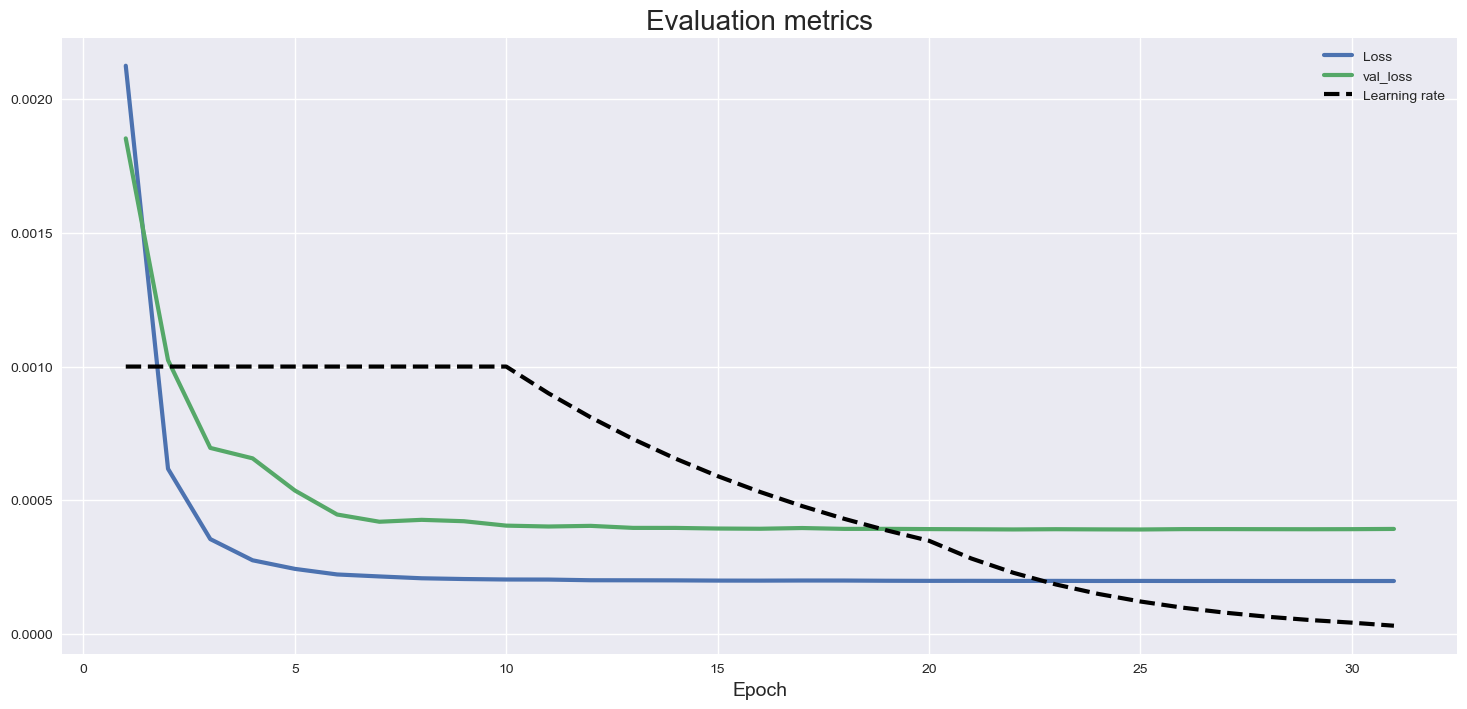

In [28]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
last_epoch = len(history.history['loss'])

plt.plot(np.arange(1, last_epoch+1), history.history['loss'], label='Loss', lw=3)
plt.plot(np.arange(1, last_epoch+1), history.history['val_loss'], label='val_loss', lw=3)
plt.plot(np.arange(1, last_epoch+1), history.history['lr'], label='Learning rate', color='#000', lw=3, linestyle='--')
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.savefig('eval_vs_lr.jpg', dpi=300, bbox_inches='tight');

In [29]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm_1 (BatchNormali  (None, 5, 19)             76        
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 5, 512)            1089536   
                                                                 
 LSTM_2 (LSTM)               (None, 512)               2099200   
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Returns (Dense)             (None, 2)                 514       
                                                                 
Total params: 3320654 (12.67 MB)
Trainable params: 3320616 (12.67 MB)
Non-trainable params: 38 (152.00 Byte)
_____________

Text(0.5, 1.0, 'RMSE Loss: Training and Validation')

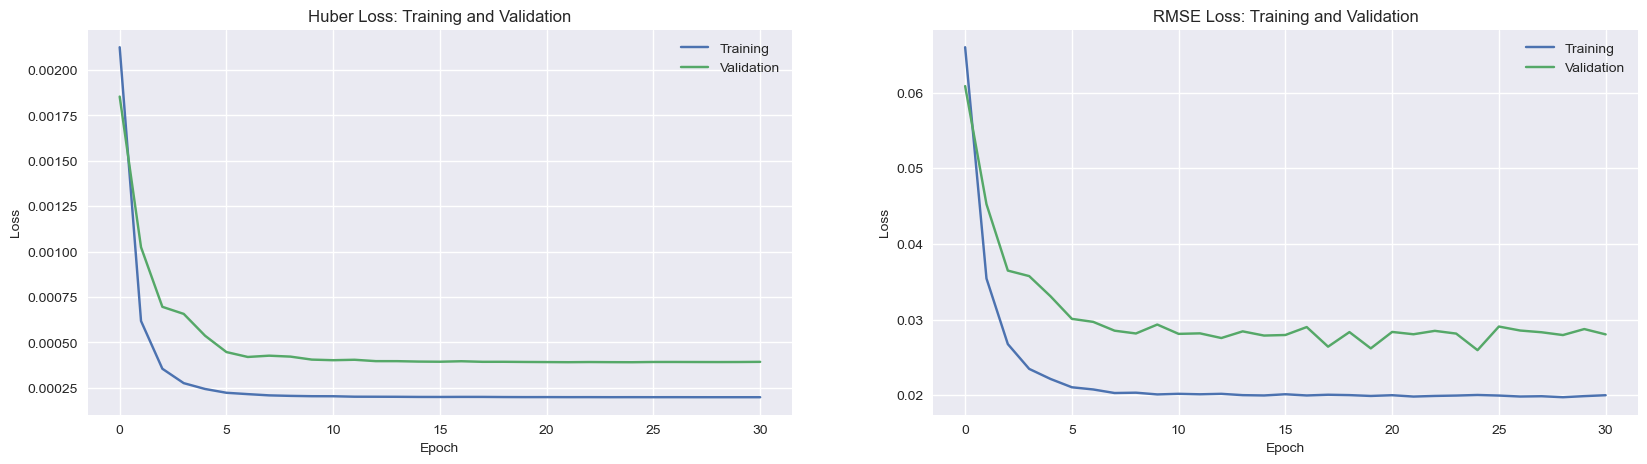

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])
plt.title('Huber Loss: Training and Validation')
plt.subplot(1,2,2)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])
plt.title('RMSE Loss: Training and Validation')

In [31]:
model_1.evaluate(my_window.test)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 110ms/step - loss: 2.9326e-04 - root_mean_squared_error: 0.0242 - mae: 0.0156


[0.0002932579373009503, 0.024218089878559113, 0.015590352937579155]

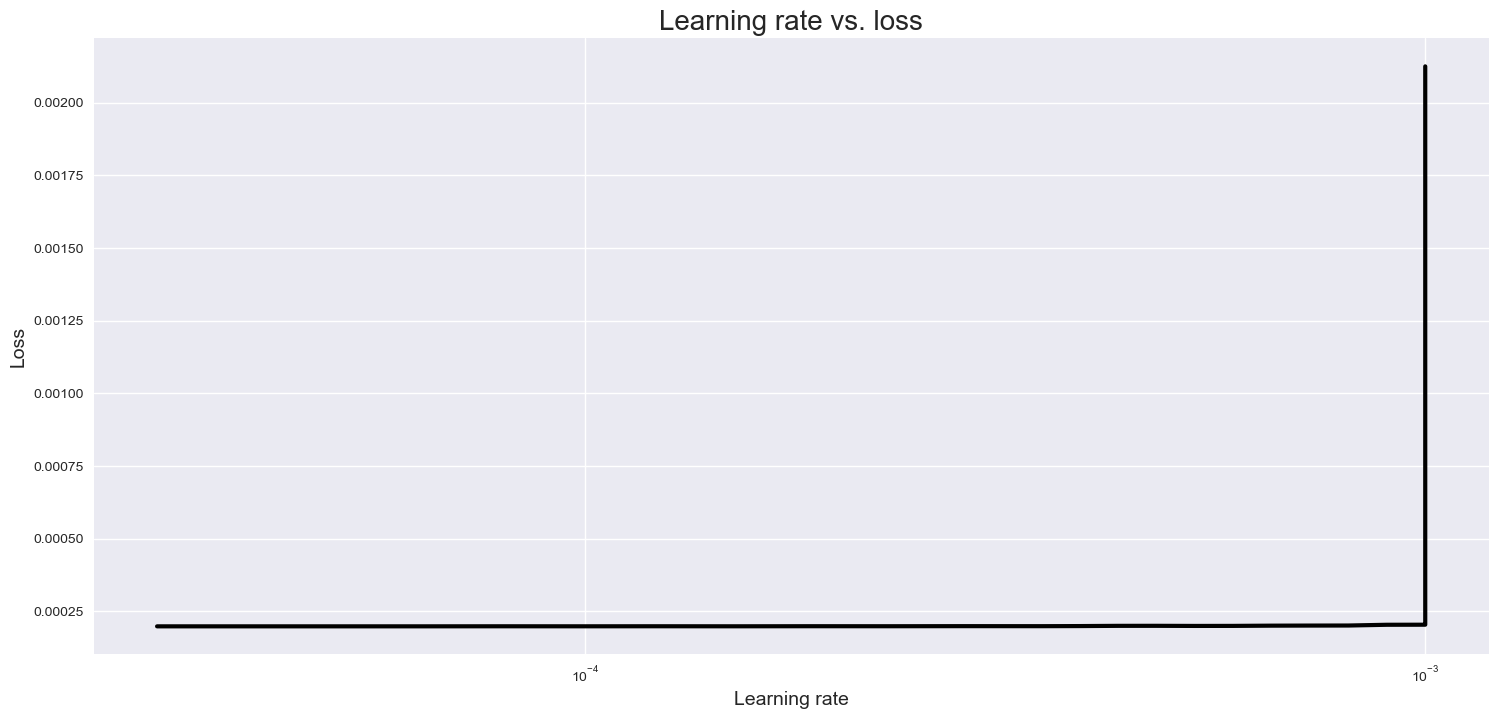

In [32]:
# learning_rates = 1e-8 * (10 ** (np.arange(num_epochs) / 20))
plt.semilogx(history.history['lr'], history.history['loss'], lw=3, color='#000')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)
plt.savefig('lr_vs_loss.jpg', dpi=300, bbox_inches='tight');

In [33]:
def plot_window(tickers,window_dataset,pandas_dataset,window_size,model,
                figsize=(12,100)):
    """This function plots the observed returns inside a tf.data.Dataset and
    compares them with the predicted returns of a model.

    Inputs:
    -------
    window_dataset (tensorflow.data.Dataset object): dataset with both inputs
        and target values.
    pandas_dataset (pandas DataFrame): dataframe that was used to create the
        window_dataset.
    window_size (int): window size used in the transformation from sequential 
        time series into window time series.
    model (model object): trained model with the capability to predict in a
        similar manner than tensorflow.keras.Model object.
    figsize (tuple, default=(12,100)): tuple with the dimensions of the figure
        where the data will be plotted.
    
    Ouputs:
    -------
    None
    """
    # Determine the X-axis of the plot:
    plot_index = pandas_dataset.iloc[window_size:,:].index

    # Assign in the addecuate format the values of the observed taget variable(s):
    y = np.concatenate([targets for inputs,targets in window_dataset],axis=0)
    
    # Use the model to predict the target variable(s):
    
    y_hat = model.predict(window_dataset)
    print("printing y hat of plot_window function")
    print(y_hat)
    # Adjust the shapes:
    y = y.reshape(y_hat.shape)
    print("printing y of plot_window function")
    print(y)

    # Plot the data:
    
    for ticker in tickers:
        for n in range(y_hat.shape[1]):
            plt.figure(figsize=figsize)
            plt.subplot(y_hat.shape[1],1,n+1)
            plt.ylabel('Return')
            plt.plot(plot_index,y_hat[:,n],label='Predicted',color='maroon')
            plt.plot(plot_index,y[:,n],label='Observed',color='midnightblue',alpha=0.5)
            plt.title(ticker)
            plt.legend()

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
6/6 [==============================] - 1s 63ms/step
printing y hat of plot_window function
[[ 0.00273609  0.00308751]
 [ 0.00441572  0.00332661]
 [ 0.00426211  0.00380772]
 ...
 [-0.0048443  -0.00219737]
 [-0.00794057 -0.00362091]
 [-0.00563674 -0.00326144]]
printing y of plot_window function
[[ 3.71002220e-03  6.03539916e-03]
 [-4.54943441e-03  2.17211265e-02]
 [ 4.85592289e-03 -1.82223436e-03]
 ...
 [-8.68003466e-04  1.19247530e-02]
 [-1.54438999e-03 -3.18802631e-05]
 [-6.67052204e-03 -1.43644605e-02]]


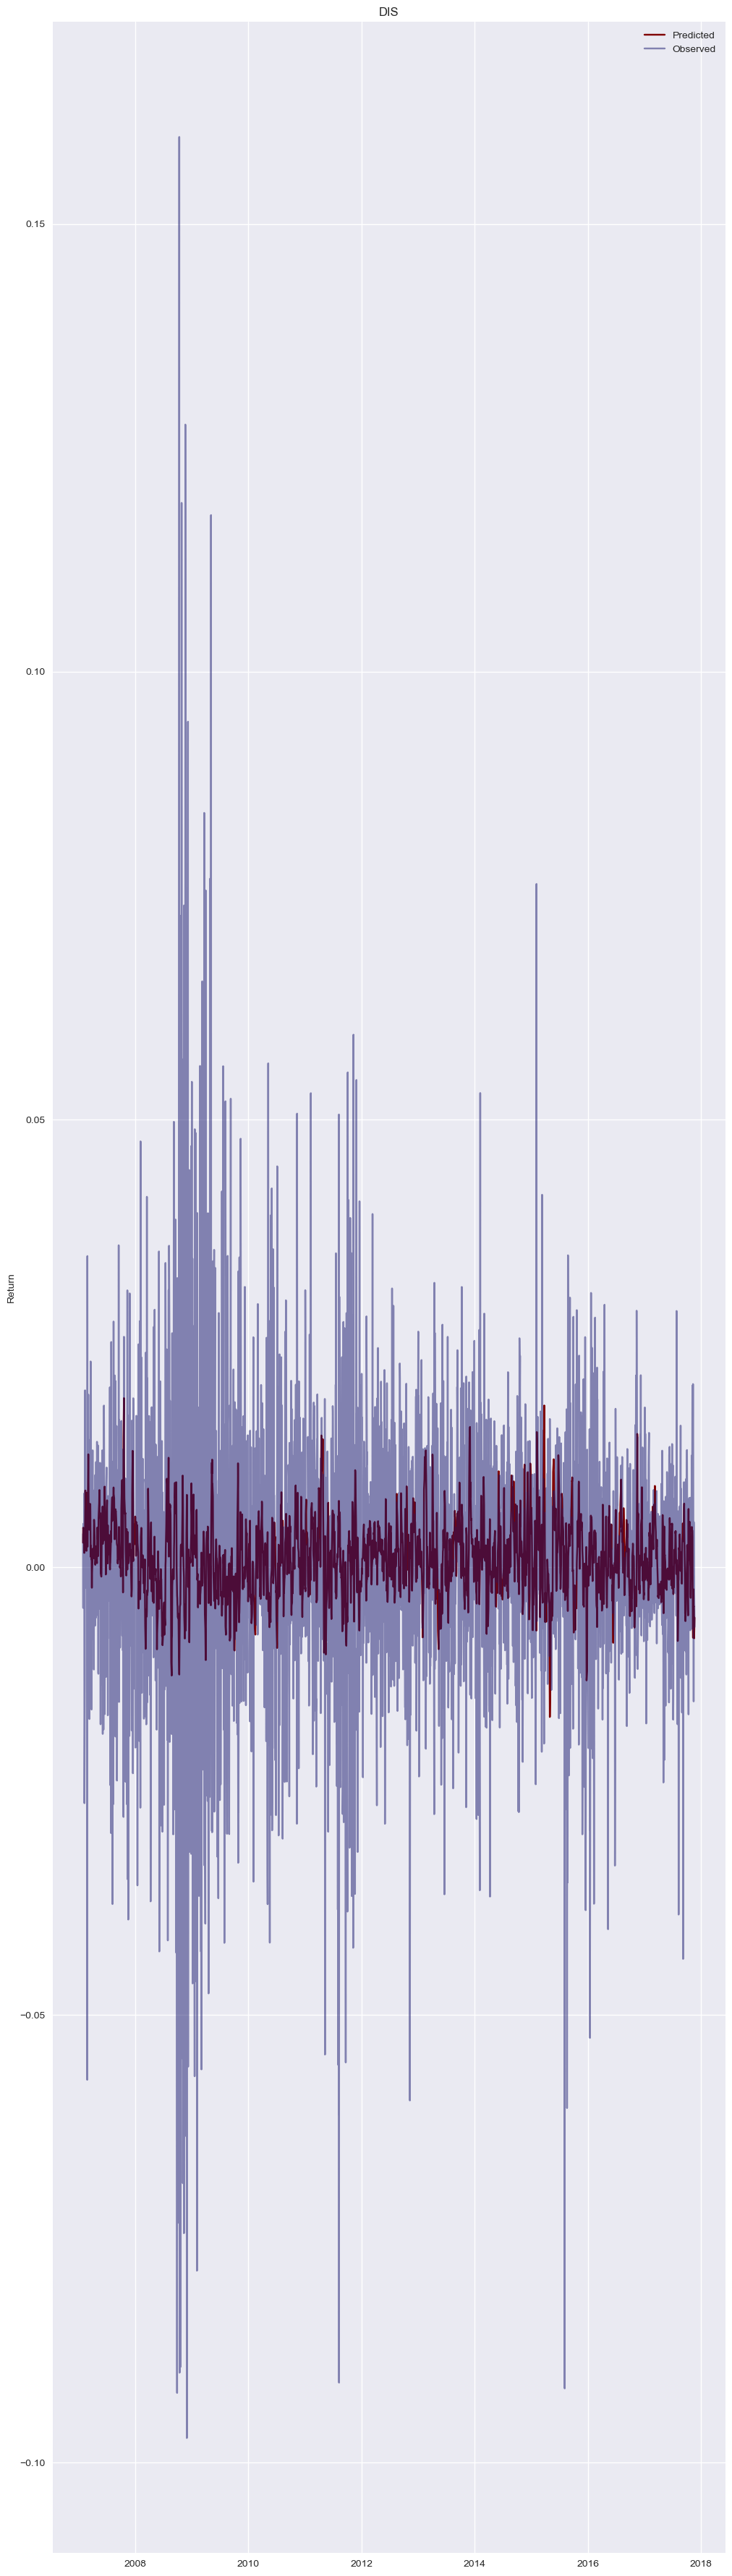

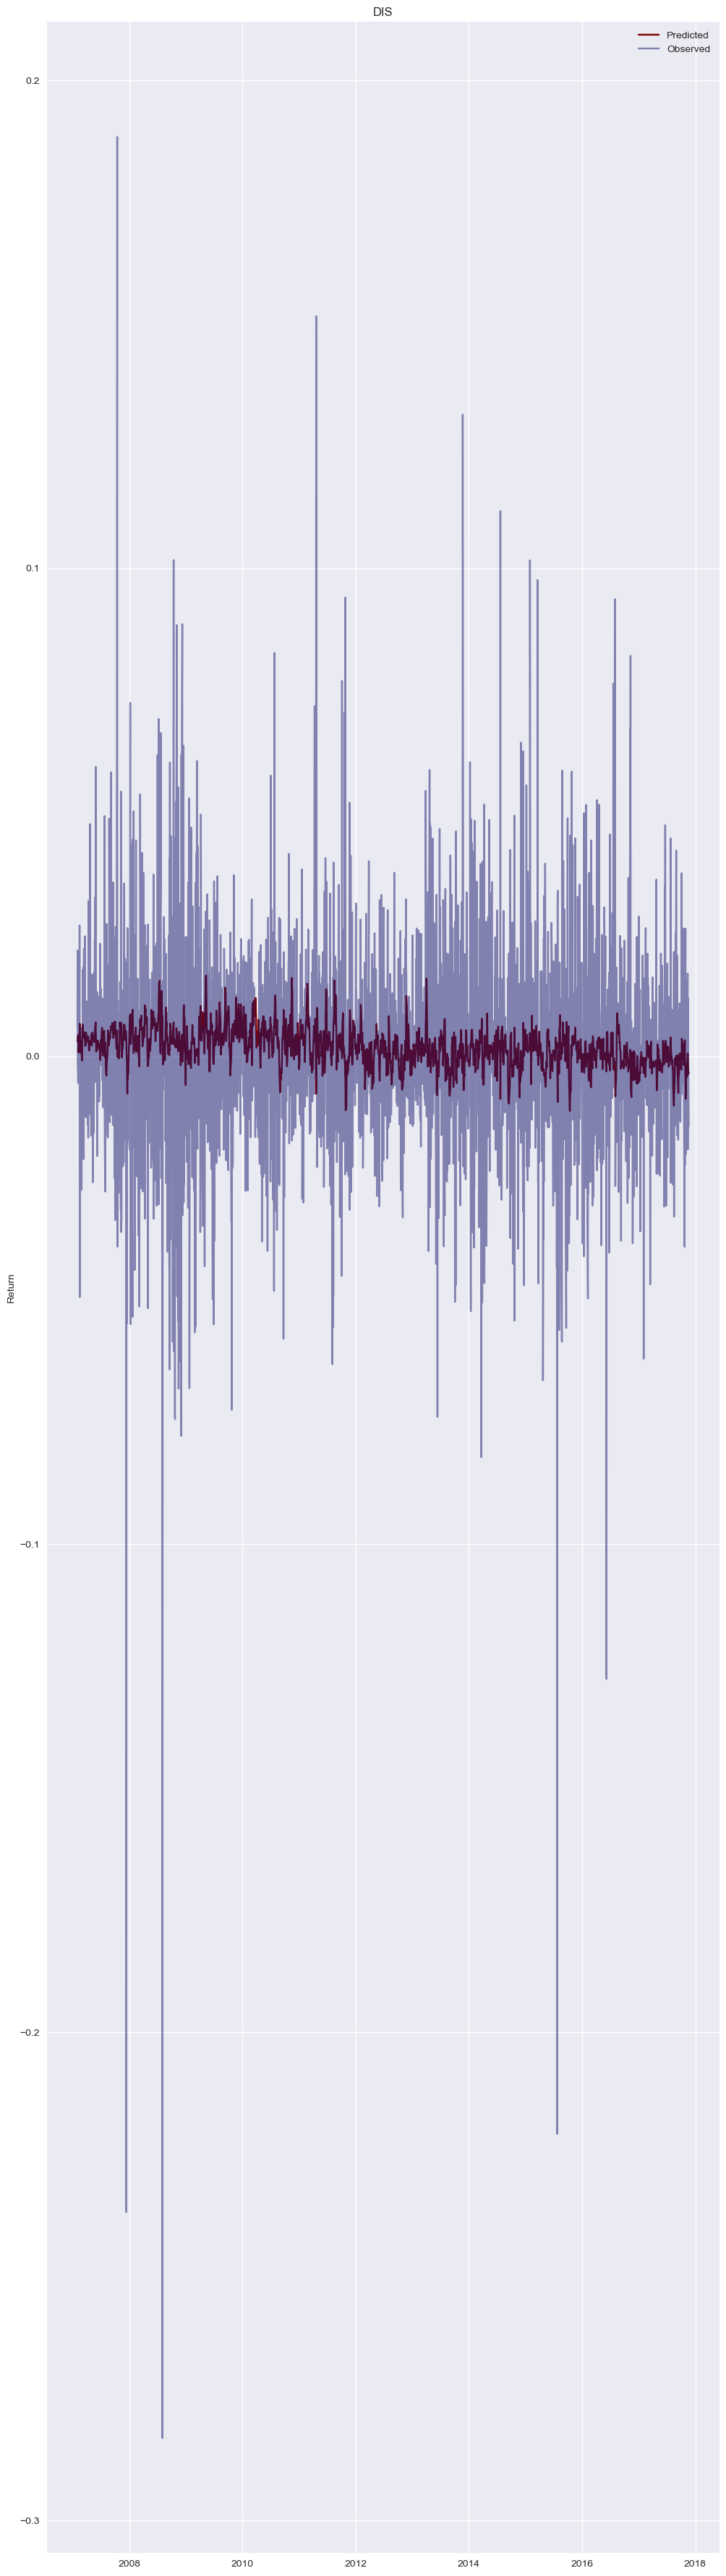

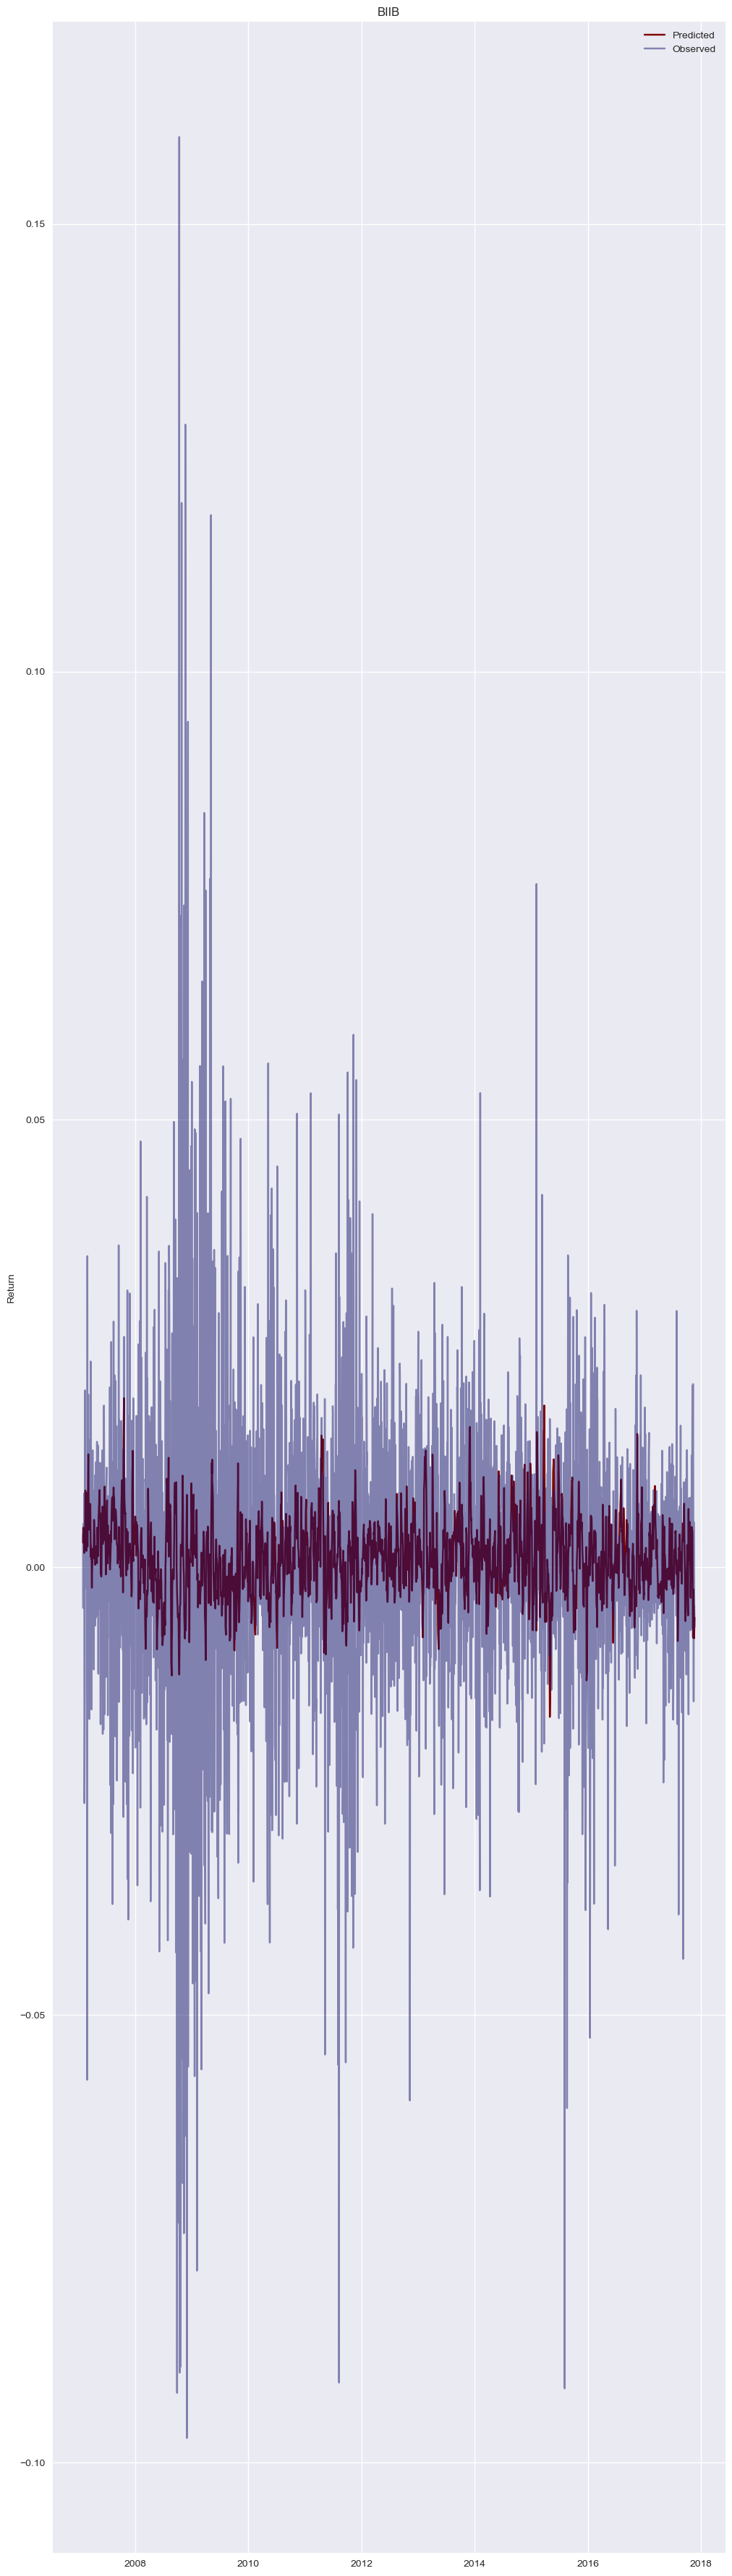

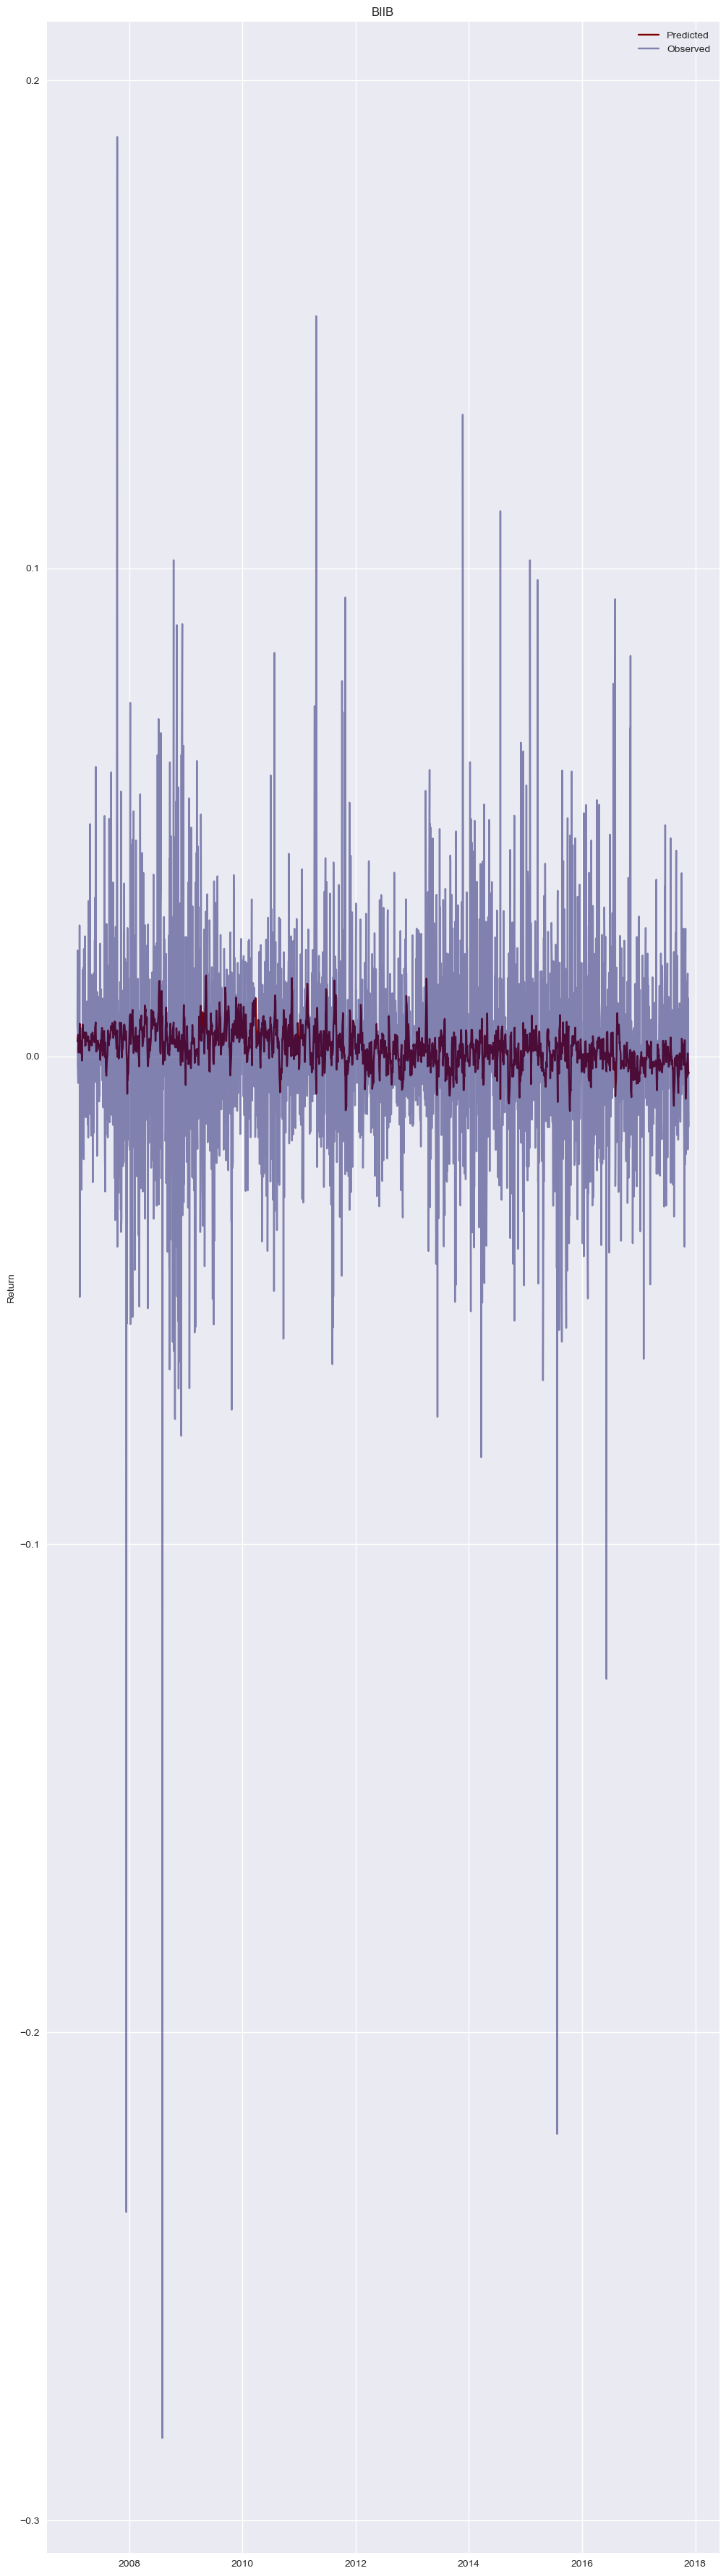

In [34]:
############# Training Results
# Create new WindowGenerator with the data not shuffled:
my_window_2 = WindowGenerator(
    input_width=window_size,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=label_cols,
    batch_size=batch_size,
    shuffle=False)

plot_window(tickers,my_window_2.train,train_df,window_size,model_1)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 80ms/step
printing y hat of plot_window function
[[-6.24650344e-03  1.08184456e-03]
 [-8.46583582e-03 -4.04576946e-04]
 [-9.39902663e-03  1.40850618e-03]
 [-1.23284236e-02  5.49674034e-03]
 [-1.16467495e-02  6.06952049e-03]
 [-1.24257952e-02  9.96356644e-03]
 [-8.68706964e-03  3.08352313e-03]
 [-7.12489523e-03 -1.52430963e-03]
 [-3.52262543e-03 -8.70600517e-04]
 [-2.18243734e-03  2.23269977e-04]
 [-1.13666547e-03 -3.70999589e-03]
 [-3.12395860e-05 -5.00556873e-03]
 [ 1.17289333e-03 -3.74506437e-03]
 [-5.30612306e-04 -1.59796840e-03]
 [-5.25479577e-03  1.62422494e-03]
 [-5.70766348e-03  3.11554456e-03]
 [-5.40078338e-03  2.69078510e-03]
 [-5.13687544e-03  1.73048046e-03]
 [-3.36195505e-03 -1.36789796e-03]
 [-3.51238134e-03 -2.43339408e-03]
 [-1.3598

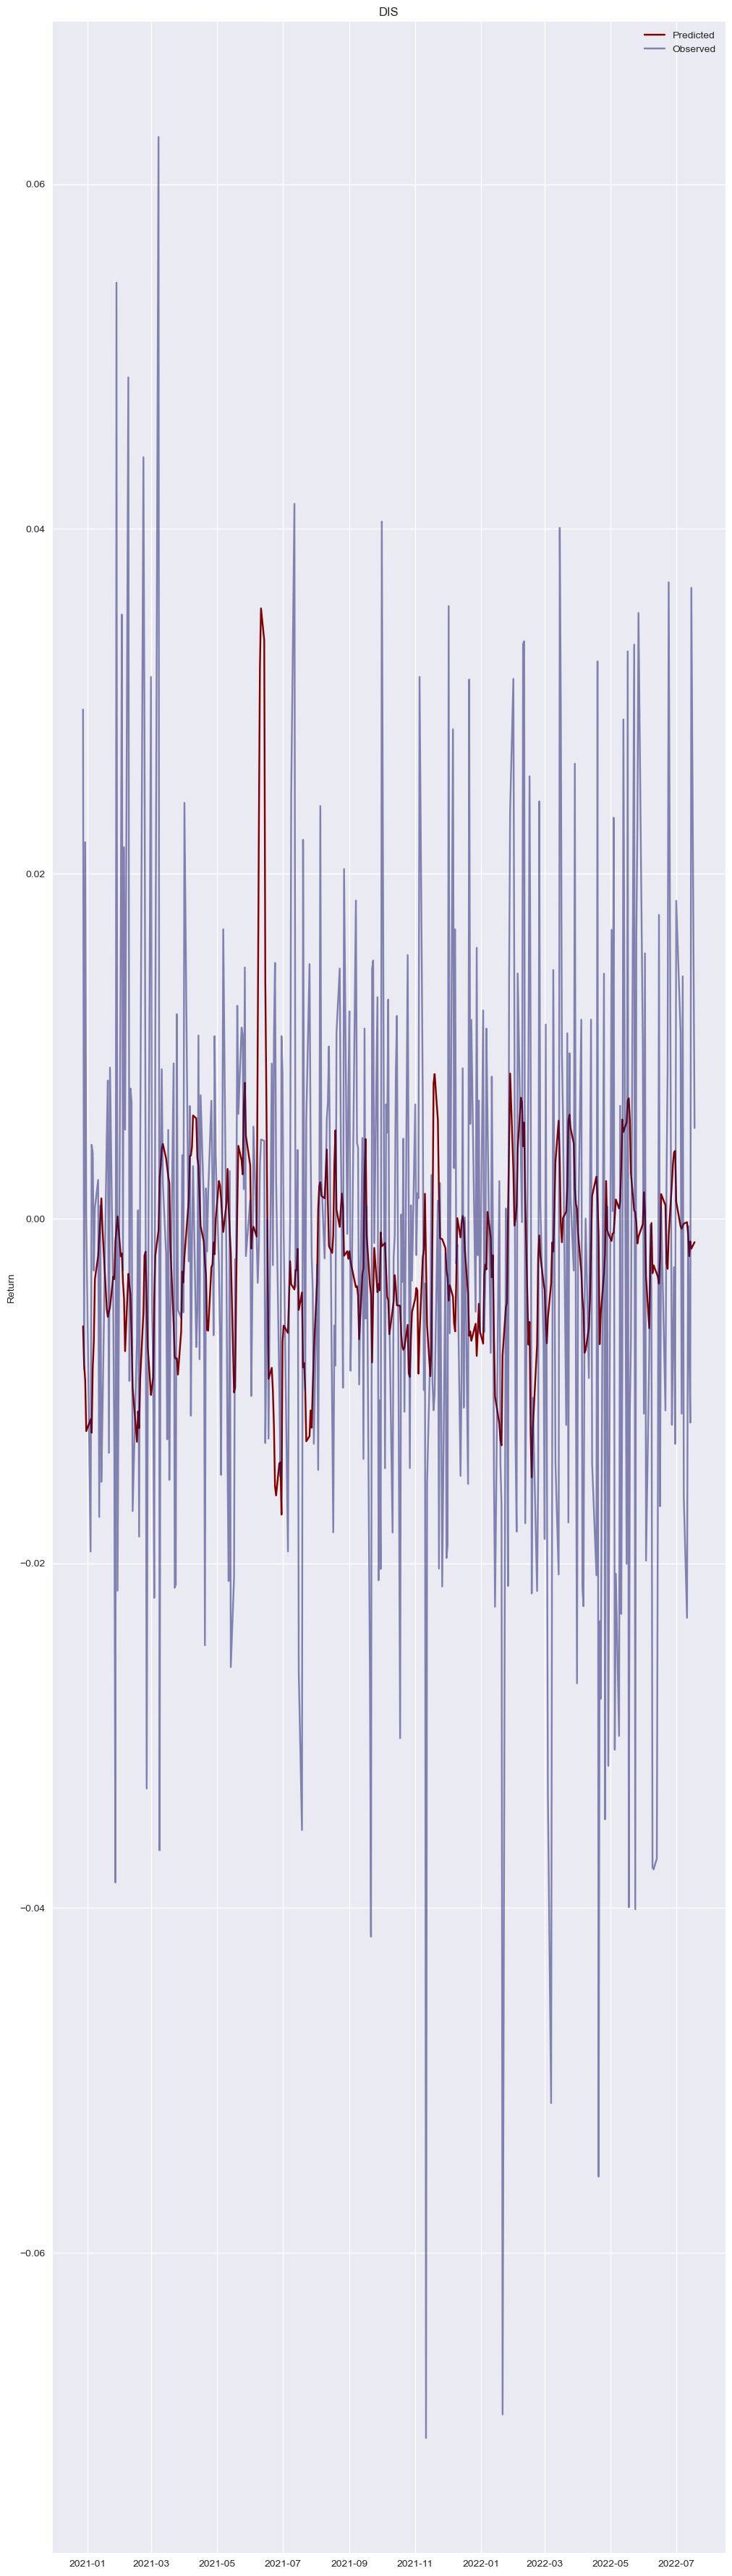

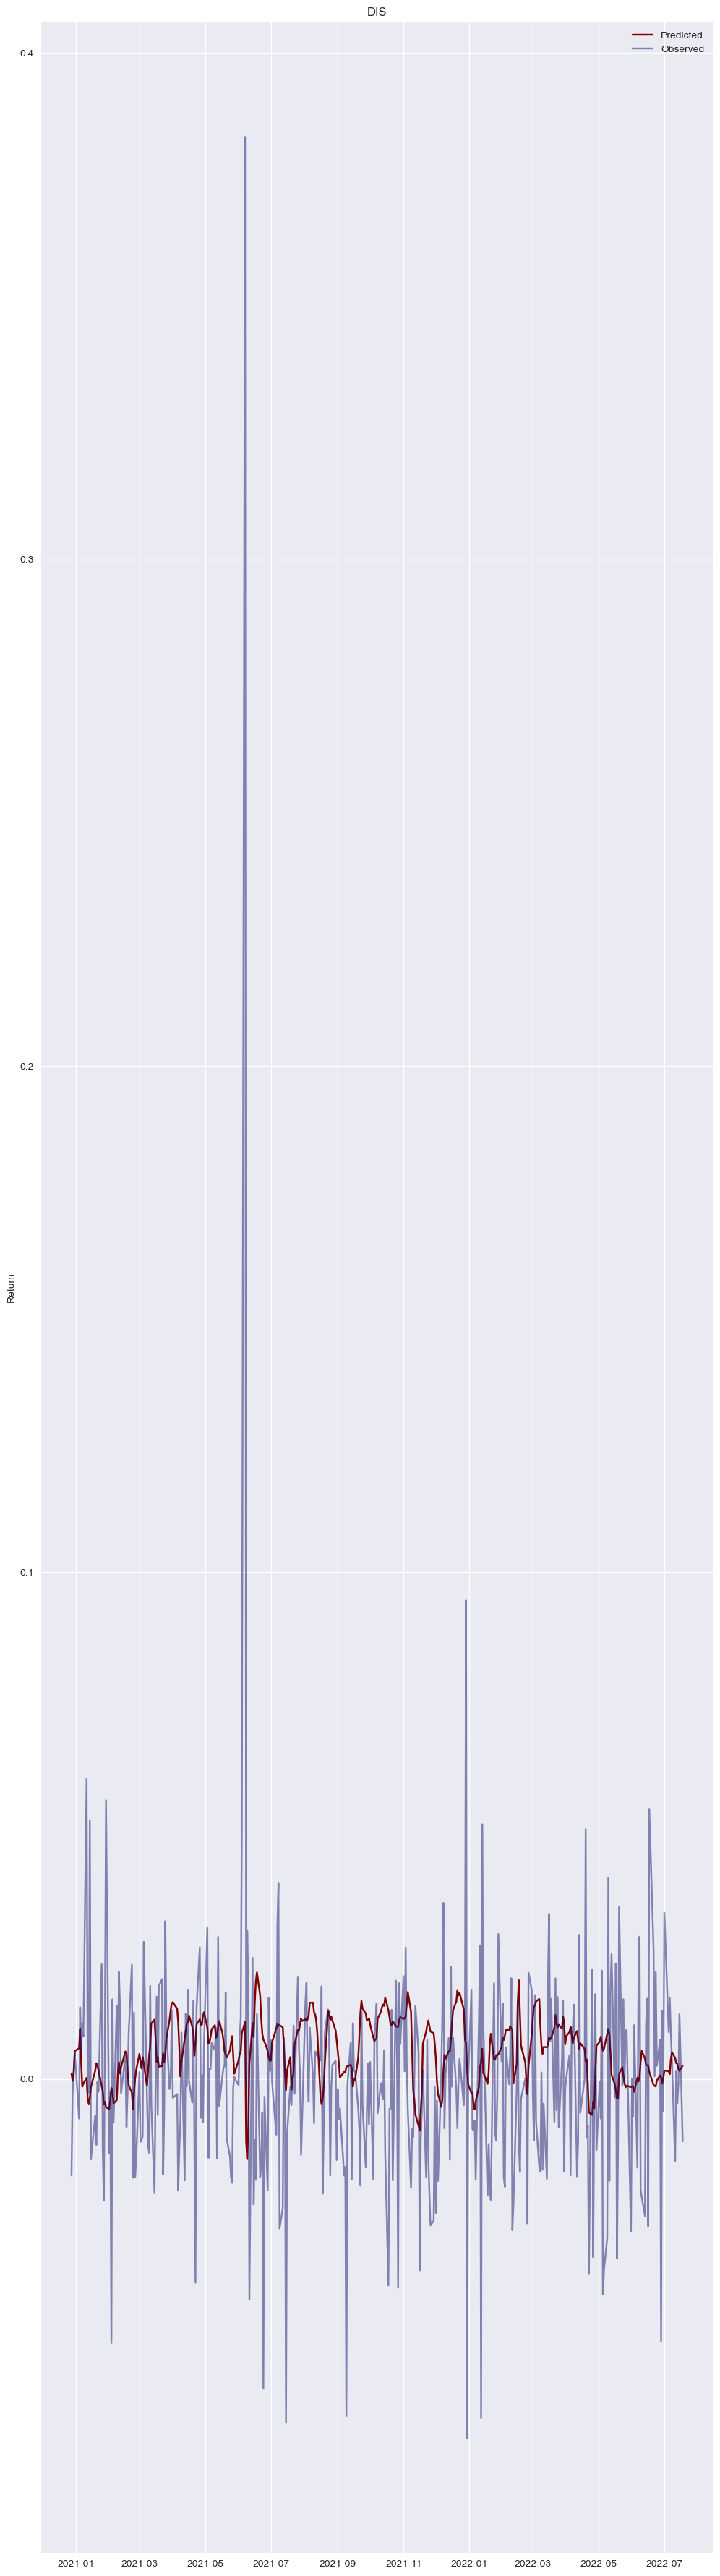

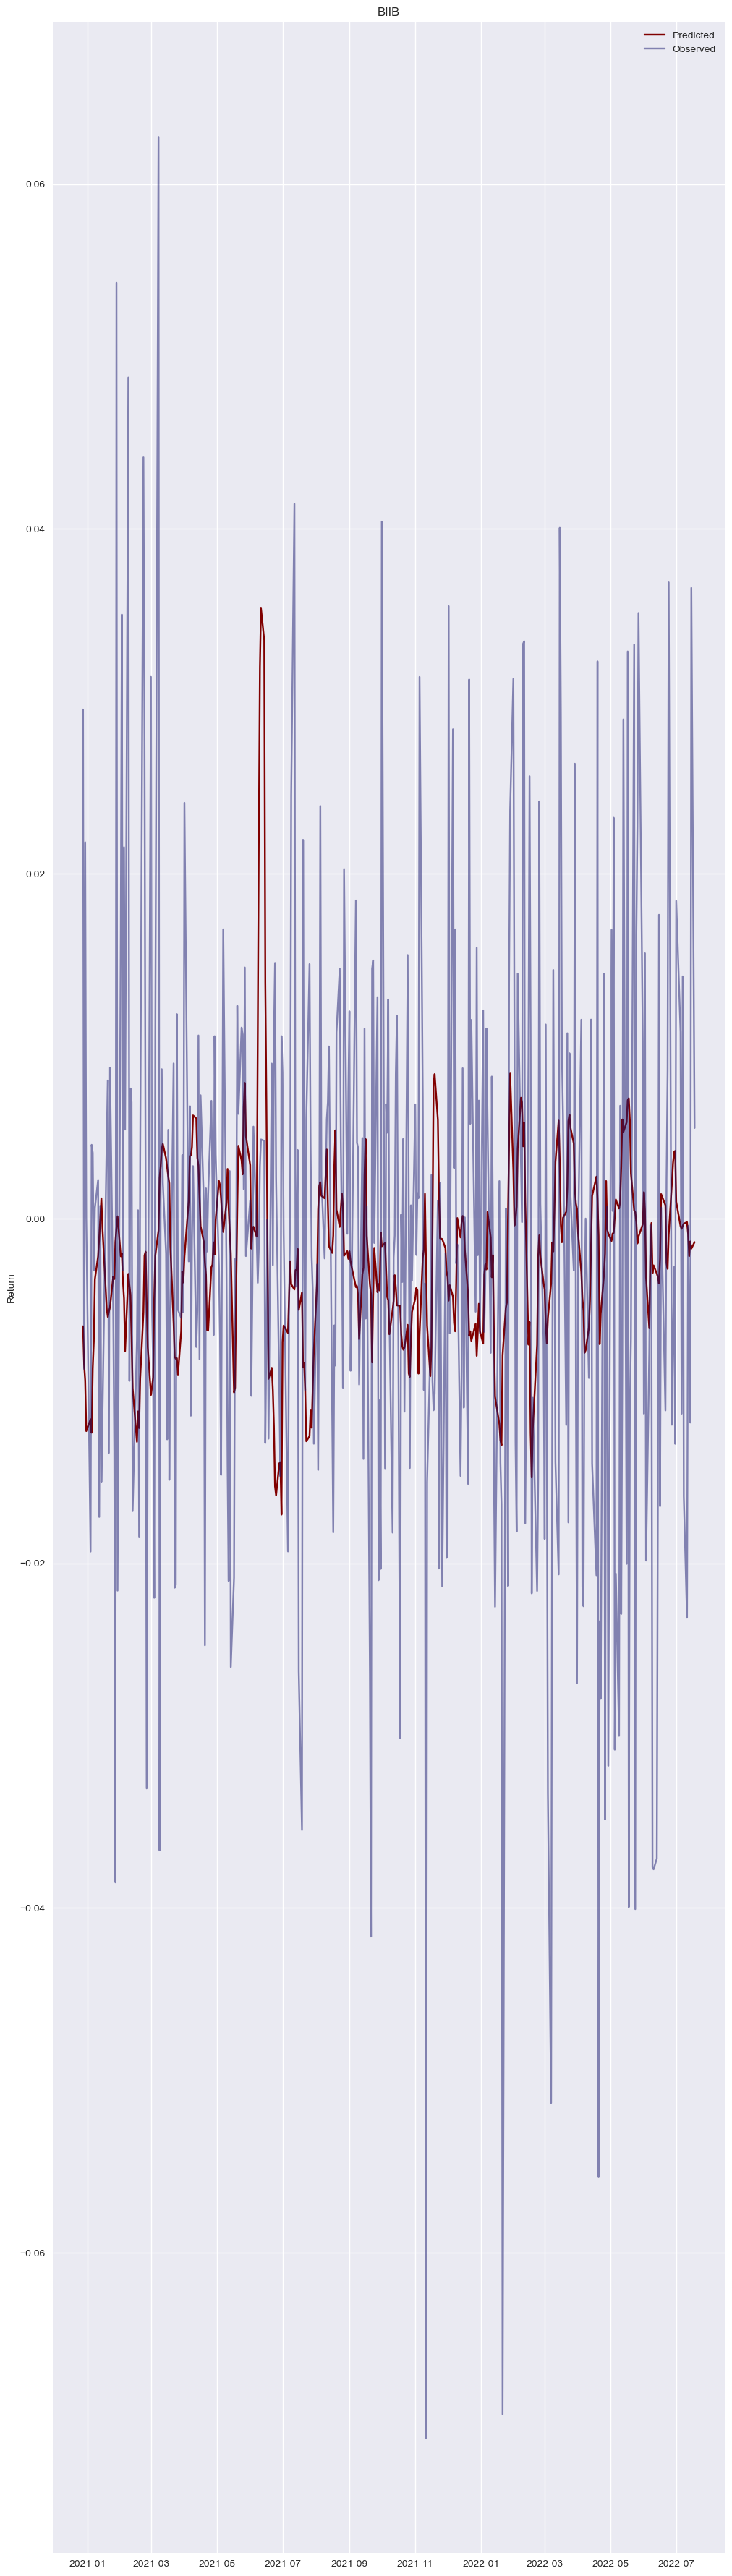

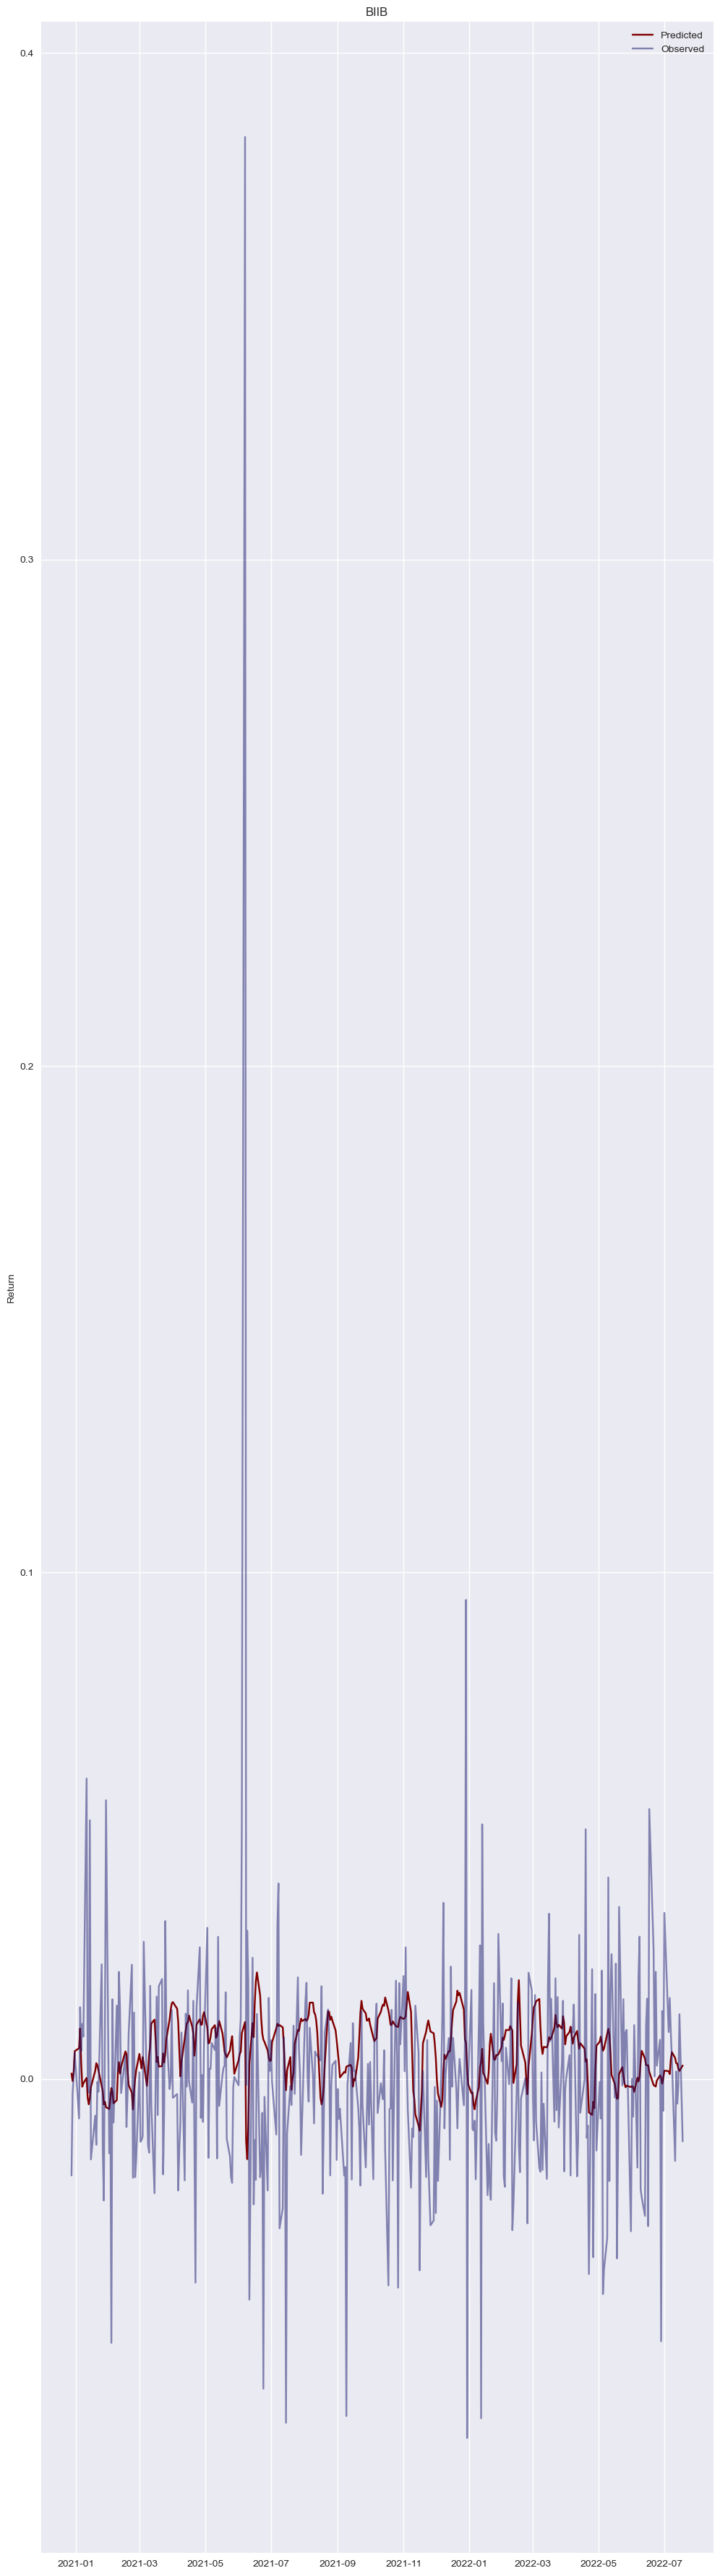

In [35]:
plot_window(tickers,my_window_2.test,test_df,window_size,model_1)